# Check vocab overlap (SW + hypernym datasets)

In [1]:
import os, sys 
import pandas as pd
pd.options.display.max_columns=500
pd.options.display.max_colwidth=1000
import matplotlib.pyplot as plt
from tqdm import tqdm 
tqdm.pandas()
import re 
from collections import Counter, defaultdict, OrderedDict
import seaborn as sns
from copy import deepcopy
from tabulate import tabulate, simple_separated_format
from inflection import singularize, pluralize
from df_to_latex import DataFrame2Latex
from collections import Counter, defaultdict
from inflection import singularize, pluralize

from utils_path import dataset_to_respath
# # Using WN, WN.taxonomy to retrieve path distance 
# - Pointers: 
#     - https://wn.readthedocs.io/en/latest/setup.html
#     - https://wn.readthedocs.io/en/latest/api/wn.html
# 
# - Installation: 
# ```
# !pip install wn
# !pip install wn[web]
# wn.download('ewn:2020')
# ```

# get the co-hyponyms from WordNet (Shick and Schutze, 2020)
# - get the hypernyms, maxinum d(x,y) is 2
# - get the top 2 most frequent senses of each hypernym 
# - get hyponyms of each hypernyms, maxinum distance d(y,z) is 4 
# - constrain the depeth of hypernyms to be 6

# In[201]:


import re 
import wn, wn.taxonomy
ewn = wn.Wordnet('ewn:2020')

def test_min_depth():
    for word in ['concept', 'thought', 'living thing', 'whole', 'psychological feature', 'unit', 'artifact', 'abstraction', 'object','physical entity', 'entity']:
        synset = wn.synsets(word, pos='n')[0]
        min_depth = wn.taxonomy.min_depth(synset, simulate_root=False)
        print(word, min_depth)


def get_inherited_hypernyms(word, k_synset, max_path_hyper, min_taxo_depth=6, print_flag=False):
    '''
    k_synset: the most frequent k_synset of word
    max_path_hyper: up to k level of hypernyms, e.g., 2 level higher than word 
    min_taxo_depth=6: concept, exluded hypernyms: unit, object, artifact, entity
    '''
    
    hyper_synsets = []
    for i, synset in enumerate(wn.synsets(word, pos='n')[:k_synset]): #top K senses of word 
        #print(f"{word} synset {i+1}")
        for j, path in enumerate(wn.taxonomy.hypernym_paths(synset)): #retrieve the hyper path for each synset 
            #print(f"path {j}")
            for i, ss in enumerate(path[:max_path_hyper]): # get the hypernyms within max_path_hyper
                ss_min_txo_depth = wn.taxonomy.min_depth(ss, simulate_root=False)
                
                if ss_min_txo_depth< min_taxo_depth: continue  #remove general concepts like "entity", 'physical entity'
                hyper_synsets.append(ss)
                if print_flag: 
                    print(' ' * i, ss, ss.lemmas()[0], ss_min_txo_depth)
                    
    return hyper_synsets

def get_direct_hyonyms(synsets):
    '''
    Return the direct hyponyms of a given list of synsets
    ''' 
    sister_synsets = []
    for synset in synsets: 
        sister_synsets.extend(synset.hyponyms() )
    return sister_synsets


def get_inherited_hyponyms(initial_synsets, max_path_hypo):
    synsets = initial_synsets
    synsets_hyponyms = []
    
    while max_path_hypo>0:
        synsets = get_direct_hyonyms(synsets)
        synsets_hyponyms.extend(synsets)
        max_path_hypo -=1
        #print(dist)
        #print(synsets)
        #print("-"*80)
    #print(Counter(synsets_all).most_common())
    return synsets_hyponyms


def filter_cohyponyms(word, synsets_cohyponyms, top_k=50):
    cohyponyms = []
    for synset in synsets_cohyponyms:
        for lemma in synset.lemmas():
            if lemma == word: continue 
            if len(lemma.split(" ")) >1 or len(lemma.split("-")) >1: continue 
            cohyponyms.append(lemma.lower())
    cohyponyms = Counter(cohyponyms)
     #if top_k !=None:        
    return cohyponyms.most_common(top_k)
    #else:
    #    return dict(cohyponyms.most_common())

    
def get_cohyponyms(word, top_k_cohyonyms=50, top_k_word_synset=2, max_path_hyper=2, max_path_hypo =4, print_flag=False):
    
    hyper_synsets = get_inherited_hypernyms(word, k_synset=top_k_word_synset, max_path_hyper = max_path_hyper)
    if print_flag:
        for synset in hyper_synsets:
            print(synset, synset.lemmas())

    synsets_cohyponyms = get_inherited_hyponyms(hyper_synsets, max_path_hypo= max_path_hypo)

    concept_cohyponyms = filter_cohyponyms(word, synsets_cohyponyms, top_k=top_k_cohyonyms)
    return list(dict(concept_cohyponyms).keys())
   

def test_get_cohyponyms(word, test_cohyponyms):
    '''
    word = 'corn'
    test_cohyponyms = ['bean', 'potato', 'barley', 'wheat', 'pea'] 
    word = 'train'
    test_cohyponyms = ['bus', 'plane', 'car', 'tram', 'truck']
    test_get_cohyponyms(word,test_cohyponyms )
    '''
    top_k_cohyonyms = None #200 
    top_k_word_synset = 2
    max_path_hyper = 2
    max_path_hypo = 4

    concept_cohyponyms  = get_cohyponyms(word, top_k_cohyonyms=top_k_cohyonyms, 
                                         top_k_word_synset=top_k_word_synset, 
                                         max_path_hyper=max_path_hyper, max_path_hypo = max_path_hypo)
    
    for query in test_cohyponyms:
        if query in concept_cohyponyms:
            print(query, 'yes')
        else:
            print(query, 'no')
    print(len(concept_cohyponyms), concept_cohyponyms)



# # Evaluation 

# In[225]:


def merge_predictions_in_concept_level(words, uniform_funcion=None, top_k=None ):
    '''
    uniform_function: either signualarize or pluralize 
    '''
    words_uniformed = [uniform_funcion(word) for word in words] if uniform_funcion !=None else words
    concepts = list(OrderedDict.fromkeys(words_uniformed))
    return concepts[:top_k] if top_k is not None else concepts

def concept_evaluation(label, pred):
    '''
    
    label: a list with the singualr and plural labels (e.g., ['tool', 'tools'])
    pred: the top K prediction list 

    return:
        1 if label share with pred else 0  
    '''
    if not isinstance(label, list):
        label = eval(label)
        
    if not isinstance(pred, list):
        pred = eval(pred)

    shared = set(label).intersection(set(pred))
    return 1 if len(shared)>0 else 0 
    # return len(shared)/len(pred)
    

def get_precision_at_k_concept(df, relation, pred_cols, label_col, k_list, pred_col_suffix='obj_mask_'):
    '''
    evalaute model predictions in concept level, ignoring the morphology affects (singular, plural)
    '''

    p_at_x = [] #defaultdict() 
    for pred_col in pred_cols: 
        suffix = pred_col.replace(pred_col_suffix, "")
        prec_cur = defaultdict()
        prec_cur['mask_type'] = suffix
        for k in k_list: 
            df[f'p{k}_{suffix}'] = df[[label_col, pred_col]].apply(lambda x: concept_evaluation(x[0], eval(x[1])[:k] if isinstance(x[1], str) else x[1][:k]), axis=1 )
            prec_cur[f'p@{k}'] = round(df[f'p{k}_{suffix}'].mean() , 3)*100

        p_at_x.append(prec_cur)  
        

    # aggregate the average precision across k 
    df_res = pd.DataFrame(p_at_x) #, columns=['mask_type', 'mAP'])
    df_res['relation'] = [relation]*len(df_res)
    return df_res

def get_highest_mrr_among_labels(label, pred):
    '''
    return the highest rank among the multiple labels. This is applicable to single labels as well, if we the single label is put in a list

    pred: a list of words (candidates)
    label: the true labels, which is a list (different forms of a word, e.g., singular or plurs, like animal and animals)
    '''
    mrr = 0 
    if pred is None: return mrr 

    rank_list = [ pred.index(item) + 1 for item in label if item in pred] 
    if len(rank_list)>0:
        mrr = 1/min(rank_list)

    return mrr 


def get_mrr(df, relation, pred_cols, label_col, pred_col_suffix):
    '''
    mrr is calculated based on the top_k rank, all elements in obj_col are used
    '''

    mrr = [] 
    for i, pred_col in enumerate(pred_cols):
        cur_mrr = defaultdict()
        suffix = pred_col.replace(pred_col_suffix, "")

        df[f'mrr_{suffix}'] = df[[label_col, pred_col]].apply(lambda x: get_highest_mrr_among_labels(x[0], x[1]), axis=1 ) 
        
        cur_mrr['mask_type'] = suffix
        cur_mrr[f"mrr"] = round(df[f'mrr_{suffix}'].mean(), 3)*100
        mrr.append(cur_mrr)

    mrr_df =  pd.DataFrame(data = mrr) #, columns=['mask_type', 'mrr'])
    # mrr_df['mask_type']= mrr_df['mask_type'].apply(lambda x: x.replace(""))
    mrr_df['relation'] = relation
    return mrr_df 


# In[202]:


def get_dataset_to_respath(dataset_to_respath, print_flag=False):
    # remote path 
#     dataset_to_respath = {'hypernymsuite-BLESS': 'log/bert-large-uncased/hypernymsuite/BLESS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'lm_diagnostic_extended-singular': 'log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv', 'clsb-singular': 'log/bert-large-uncased/clsb/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.CLSB.csv', 'hypernymsuite-LEDS': 'log/bert-large-uncased/hypernymsuite/LEDS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'hypernymsuite-EVAL': 'log/bert-large-uncased/hypernymsuite/EVAL/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'hypernymsuite-SHWARTZ': 'log/bert-large-uncased/hypernymsuite/SHWARTZ/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv'}

    source_dir = 'spartan:~/cogsci/DAP/'
    target_dir = '../../'
    dataset_to_localpath = defaultdict()
    dataset_rename = {
        'hypernymsuite-BLESS': 'BLESS', 'lm_diagnostic_extended-singular': 'DIAG', 'clsb-singular':'CLSB', 'hypernymsuite-LEDS': 'LEDS', 'hypernymsuite-EVAL': 'EVAL', 'hypernymsuite-SHWARTZ': 
        "SHWARTZ"
    }
    for dataset, path in dataset_to_respath.items():
        path = path.replace(".tsv", ".csv")
        source_path = source_dir + path 
        dataset_l1 = dataset.split("-")[0]
        dataset_l2 = dataset.split("-")[1] 
        target_path = target_dir + path
        scp_string = f"!scp {source_path} {target_path}"
        if print_flag:
            print(scp_string)
            print()
#         print(target_path)
        dataset_to_localpath[dataset_rename[dataset]] = target_path 
#     print(dataset_to_localpath)
    return dataset_to_localpath
dataset_to_localpath = get_dataset_to_respath(dataset_to_respath)


from nltk.corpus import wordnet 
wn_lemmas = set(wordnet.all_lemma_names())
def check_word_in_wordnet(word, wn_lemmas):
    '''
    1 if word in wordnet else 0
    '''
    return 1 if word in wn_lemmas else 0 


def get_all_vocab(dataset_to_localpath):
    dataset_to_df = defaultdict()
    vocab_sub = set()
    for dataset, path in dataset_to_localpath.items(): 
        if debug:
           if dataset!='DIAG': continue 
        print("dataset", dataset)
        df = pd.read_csv(path)
        vocab_sub.update(df['sub_label_sg'].to_list())
        print(len(vocab_sub))
    return list(vocab_sub)




## Config for getting co-hyponyms from WordNet
top_k_cohyonyms = None #200 
top_k_word_synset = 2
max_path_hyper = 2
max_path_hypo = 4

#config for evaluation 
pred_col_suffix=''
label_col = 'sub_sister_new'
pred_cols = ['subj_anchors_all_sg']
relation='co-hyponyms'
debug= False #True #eval(sys.argv[1])
print("debug", debug)


vocab_sub = get_all_vocab(dataset_to_localpath)
word_to_cohyponyms = defaultdict(list)

# for i, word in enumerate(vocab_sub):
#     if i%10==0: print(i)
#     if not check_word_in_wordnet(word, wn_lemmas):
#         word_to_cohyponyms[word] = []
#     else:
#         cohyponyms = get_cohyponyms(word, top_k_cohyonyms=top_k_cohyonyms, 
#                                  top_k_word_synset=top_k_word_synset, 
#                                  max_path_hyper=max_path_hyper, 
#                                  max_path_hypo = max_path_hypo)
#         word_to_cohyponyms[word] = cohyponyms
#     if debug:
#         print(word, cohyponyms)
# df = pd.DataFrame(word_to_cohyponyms.items(), columns=['word', 'cohyponyms'])
# output_path = '../log/word_to_cohyponyms.txt'
# df.to_csv(output_path, index=False)
# print(f"save {output_path}")


debug False
dataset BLESS
200
dataset DIAG
758
dataset CLSB
1087
dataset LEDS
1987
dataset EVAL
2450
dataset SHWARTZ
12826


In [2]:
query_words = ['dog','grain', 'mountains' ]
for word in query_words: 
    cohyponyms = get_cohyponyms(word, top_k_cohyonyms=top_k_cohyonyms, 
                                      top_k_word_synset=top_k_word_synset, 
                                     max_path_hyper=max_path_hyper, 
                                     max_path_hypo = max_path_hypo)
    word_to_cohyponyms[word] = cohyponyms
print(word_to_cohyponyms[word])

[]


Current Time = 15:21:45


In [5]:
check_word_in_wordnet('mountain', wn_lemmas)

1

In [24]:
import pandas as pd
from collections import defaultdict 
import json 
import wn
from inflection import singularize, pluralize 
import os, sys
from wn.similarity import path
ewn = wn.Wordnet('ewn:2020')


def read_cohyponyms(path = '../log/word_to_cohyponyms.txt'):
    if os.path.exists(path):
        print(f"reading cohyponyms: {path}")
        df = pd.read_csv(path)
        word_to_cohyponym = dict(zip(df['word'], df['cohyponyms']))
        return word_to_cohyponym
    print(f"{path} not found")

    

def write_cohyponym_scores(word_to_cohyponyms_score, output_path):
    with open(output_path, 'w') as fout:
        json.dump(word_to_cohyponyms_score, fout, indent=4)
    print(output_path)

def get_path_score_for_cohyponyms(word_to_cohyponyms, debug=False):
    word_to_cohyponyms_score = defaultdict()
    if debug:    
        query_words = ['dog', 'wolf', 'corn', 'car']
    else: 
        query_words = word_to_cohyponyms.keys()
        
    for k in query_words: 
        k_pl = pluralize(k)
        cur_cohyponyms_to_score = defaultdict()
        if len(word_to_cohyponyms[k])==0: continue 
        for v in eval(word_to_cohyponyms[k]):
            score = get_shortest_path_score(k, v)
            v = pluralize(v)
            cur_cohyponyms_to_score[v] = round(score, 4)
        cur_cohyponyms_to_score = dict(sorted(cur_cohyponyms_to_score.items(), key=lambda x: x[1], reverse=True))
        word_to_cohyponyms_score[k_pl] = cur_cohyponyms_to_score
    return word_to_cohyponyms_score


if __name__=='__main__':
    debug=False 
    # debug=True 
    word_to_cohyponyms = read_cohyponyms()
    word_to_cohyponyms_score = get_path_score_for_cohyponyms(word_to_cohyponyms, debug=debug)
#     output_path = '../log/word_to_cohyponyms_score_pl.json'
#     write_cohyponym_scores(word_to_cohyponyms_score, output_path)

In [30]:
def get_shortest_path_score(word1, word2):
    synsets1 = ewn.synsets(word1, pos='n')    
    synsets2 = ewn.synsets(word2, pos='n')
    if len(synsets1)==0 or len(synsets2)==0: return 0 
    scores = []
    for synset1 in synsets1:
        for synset2 in synsets2:
            scores.append(path(synset1, synset2  ))
    return max(scores) 


In [31]:
k='tiger'
v= 'lion'
score = get_shortest_path_score(k, v)
print(score)

0.3333333333333333


In [37]:
import pandas as pd
# path = "../../log/bert-large-uncased/ALL/SWOWStrength/df_all_use_global_dap_True_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_anchor_source_WordNet_wns_False_wnf_False_swow_score_source_None.ALLSWOW.csv"
path = "../../log/bert-large-uncased/ALL/SWOWStrength/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_SWOW_swow_score_source_None.HYPERNYMSUITE.csv"
df = pd.read_csv(path)

In [49]:
set(df.query("sub_label_sg == 'lime'")['obj_label'])

{"['citrus']", "['food']", "['produce']"}

In [41]:
# # df[['sub_label', 'subj_anchors_wordnet']]
# # df.columns

Counter(df['sub_label_sg'].to_list()).most_common()

[('castle', 11),
 ('robe', 11),
 ('blouse', 11),
 ('sweater', 10),
 ('television', 10),
 ('vest', 10),
 ('shirt', 9),
 ('scarf', 9),
 ('phone', 9),
 ('jacket', 9),
 ('missile', 8),
 ('cannon', 8),
 ('library', 8),
 ('bowl', 7),
 ('spear', 7),
 ('radio', 7),
 ('pistol', 7),
 ('book', 7),
 ('rifle', 6),
 ('toaster', 6),
 ('revolver', 6),
 ('cathedral', 6),
 ('bed', 6),
 ('jet', 6),
 ('stove', 6),
 ('trumpet', 6),
 ('washer', 6),
 ('stereo', 6),
 ('tea', 6),
 ('sport', 6),
 ('catfish', 5),
 ('rabbit', 5),
 ('sieve', 5),
 ('oven', 5),
 ('bomb', 5),
 ('bomber', 5),
 ('violin', 5),
 ('chair', 5),
 ('box', 5),
 ('sofa', 5),
 ('mug', 5),
 ('spade', 5),
 ('onion', 5),
 ('sword', 5),
 ('car', 5),
 ('chestnut', 5),
 ('machete', 5),
 ('puppet', 5),
 ('baby', 5),
 ('man', 5),
 ('son', 5),
 ('iron', 5),
 ('water', 5),
 ('turtle', 4),
 ('piano', 4),
 ('pub', 4),
 ('beet', 4),
 ('clarinet', 4),
 ('cello', 4),
 ('spinach', 4),
 ('celery', 4),
 ('turnip', 4),
 ('shovel', 4),
 ('vulture', 4),
 ('apple', 

In [32]:
df.query("p10_def_sap == 1 and p10_def_dap== 0")[['sub_label', 'subj_anchors_wordnet']]

,sub_label,subj_anchors_wordnet
47,tigers,['MISSING']
59,whales,['MISSING']
66,swan,"['coscoroba', 'cygnets', 'waterfowl', 'waterbi..."
143,beetle,"['ladybeetles', 'ladybug', 'ladybird', 'longic..."
165,rats,['MISSING']
...,...,...
1984,voices,['MISSING']
1989,wars,['MISSING']
2000,wheels,['MISSING']
2004,windows,['MISSING']


In [19]:
# df.query("subj_anchors_wordnet == ['MISSING']")

,Unnamed: 0,sub_label,obj_label,relation,masked_sentences,sub_sister,uuid,sub_position,sub_label_sg,sub_label_pl,...,p5_def_dap,p10_def_dap,p1_lsp_dap,p5_lsp_dap,p10_lsp_dap,mrr_sentence,mrr_def_sap,mrr_lsp_sap,mrr_def_dap,mrr_lsp_dap


In [4]:
filepath = "../../data/hypernymsuite/ALL/SWOWStrength/IsA.jsonl"

In [5]:
import json 
import pandas as pd

with open(filepath, 'r', encoding='utf-8') as fin:
    data = fin.readlines()
    data = [eval(x) for x in data]
    df = pd.DataFrame(data)

    df['obj_label'] = df['obj_label'].apply(lambda x: [x] if isinstance(x, str) else x)
    df['masked_sentences'] = df['masked_sentences'].apply(lambda x: eval(x) if isinstance(x, str) else x)

In [34]:
path1 = "../../log/bert-large-uncased/ALL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_AddSWOWSimilar.HYPERNYMSUITE.csv"
path2 = "../../log/bert-large-uncased/ALL/SWOWStrength/df_all_use_global_dap_True_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_anchor_source_WordNet_wns_True_wnf_False_swow_score_source_None.HYPERNYMSUITE.csv"
path3 = "../../log/bert-large-uncased/ALL/SWOWStrength/df_all_use_global_dap_True_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_anchor_source_WordNet_wns_False_wnf_True_swow_score_source_None.HYPERNYMSUITE.csv"


df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)
df3 = pd.read_csv(path3)

display(df1[['sub_label', 'subj_anchors_sg']].head())

display(df2[['sub_label', 'subj_anchors_wordnet_pl']].head())

display(df3[['sub_label', 'subj_anchors_wordnet_pl']].head())


,sub_label,subj_anchors_sg
0,catfish,"['bass', 'carp', 'fish', 'trout', 'shrimp']"
1,lemon,"['lime', 'citrus', 'orange', 'grape', 'strawbe..."
2,turtles,"['snake', 'bird', 'fish', 'lizard', 'frog']"
3,bags,"['luggage', 'box', 'suitcase', 'backpack', 'tr..."
4,rabbits,"['hare', 'rodent', 'mouse', 'mammal', 'dog']"


,sub_label,subj_anchors_wordnet_pl
0,catfish,"['carp', 'basses', 'cisco', 'roe', 'herring']"
1,lemon,"['limes', 'citrus', 'orange', 'apples', 'grapes']"
2,turtles,"['snakes', 'birds', 'fishes', 'lizards', 'frogs']"
3,bags,"['boxes', 'yes', 'shoes', 'cases', 'obviously']"
4,rabbits,"['foxes', 'deer', 'squirrels', 'mice', 'rodents']"


,sub_label,subj_anchors_wordnet_pl
0,catfish,"['basses', 'carp', 'perches']"
1,lemon,"['chocolates', 'orange', 'limes', 'cherries', ..."
2,turtles,"['snakes', 'birds', 'fishes', 'lizards', 'frogs']"
3,bags,"['boxes', 'yes', 'shoes', 'cases', 'obviously']"
4,rabbits,"['foxes', 'deer', 'squirrels', 'mice', 'rodents']"


In [9]:
import json 
import pandas as pd 
from collections import defaultdict, Counter 

path = '../log/word_to_cohyponyms_score.json'
data = json.load(open(path, 'r'))

from inflection import singularize, pluralize 

data_new = defaultdict(dict)
for i, (k,v) in enumerate(data.items()):
    cur_dic = {}
    k = pluralize(k)
    for k1, v1 in v.items():
        k1 = pluralize(k1)
        cur_dic[k1] = v1 
    data_new[k] = cur_dic
    if i%1000 == 0:
        print(i)
        
out_path = '../log/word_to_cohyponyms_score_pl.json'
json.dump(open(path, 'w'))

print(f"save {out_path}")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


TypeError: dump() missing 1 required positional argument: 'fp'

ImportError: cannot import name dataclass_transform

In [8]:
from nltk.corpus import wordnet as wn
import pandas as pd
import os, sys 


def read_cohyponyms(path = '../log/word_to_cohyponyms.txt'):
    if os.path.exists(path):
        print(f"reading cohyponyms: {path}")
        df = pd.read_csv(path)
        word_to_cohyponym = dict(zip(df['word'], df['cohyponyms']))
        return word_to_cohyponym
    print(f"{path} not found")



def get_path_using_hypernym_dict(hypernym,hypernym_dict,synsets):
    '''
    Return the path between a sense and a specified hypernym 
    Core idea: starting from the hypernym, find its child sense (iterate this process, DFS)
    
    hypernym: a synset, which is a hypernym   
    hypernym_dict: a {hypernym: sense} dict 
    sensets: a synsets 
    '''
    
    path = [hypernym]
    current_synset = hypernym_dict[hypernym]
    #     print(hypernym, current_synset)
    
    while current_synset not in synsets: #stop criteria: when find a sense belonging to the synsets
    #         print(current_synset)
        path.append(current_synset)
        current_synset =  hypernym_dict[current_synset]
    path.append(current_synset)
    return path
    
# hypernym_dict = get_hypernym_path_dict(wn.synsets("book","n"))
# print(get_path_using_hypernym_dict(wn.synset('physical_entity.n.01'),hypernym_dict,wn.synsets("book","n")))
        

def get_hypernym_path_dict(synsets):
    '''
    get the hypernyms for all synsets of a given word 
    return hypernym_dict: key is the hypernym and value is the synset
    '''
    hypernym_dict = {}
    synsets_to_expand = synsets
    while synsets_to_expand:
        new_synsets_to_expand = set()
        for synset in synsets_to_expand:
            for hypernym in synset.hypernyms():
                if hypernym not in hypernym_dict:  # this ensures we get the shortest path
                    hypernym_dict[hypernym] = synset
                    new_synsets_to_expand.add(hypernym)
        synsets_to_expand = new_synsets_to_expand
    return hypernym_dict
        
def get_wordnet_shortest_path_between(word1,word2):
    '''
    get the shorttest path betwen two words
    question: what to return if a word is not in the wordnet
    '''

    synsets1 = wn.synsets(word1, "n") #""n"" is added in 230107
    synsets2 = wn.synsets(word2, "n")
    if len(synsets1)==0 or len(synsets2) ==0: return [] #retrun [] means no path exsit 
    # added these two lines to catch situation where word1 and word2 share a synset, the distance is 1, 1/path=1
    match = set(synsets1).intersection(set(synsets2))
    if match: return [list(match)[0]]

    hypernym_dict1 = get_hypernym_path_dict(synsets1)
    hypernym_dict2 = get_hypernym_path_dict(synsets2)
    best_path = []
    for hypernym in hypernym_dict1:
        if hypernym in hypernym_dict2 and hypernym_dict1[hypernym] != hypernym_dict2[hypernym]: #find the LCS
            path1 = get_path_using_hypernym_dict(hypernym,hypernym_dict1,synsets1)
            path2 = get_path_using_hypernym_dict(hypernym,hypernym_dict2,synsets2)
            
            if not best_path or len(path1) + len(path2) - 1 < len(best_path):
                path1.reverse()
                best_path = path1 + path2[1:]
    return best_path

    
def get_wordnet_shortest_path_length_between(word1,word2, oov_path_len=100):
    '''
    oov_path: the path for out-of-vocabulary words
    '''
    best_path = get_wordnet_shortest_path_between(word1, word2)    
    return len(best_path) if len(best_path)>0 else oov_path_len 

def get_wordnet_shortest_path_score_between(word1,word2):
    '''
    path_score = 1/short_path_length(word2, word2)
    path_score=0 if word1/word2 is not in wordnet 
    '''
    best_path = get_wordnet_shortest_path_between(word1, word2)    
    return 1/len(best_path) if len(best_path)>0 else 0



def get_wordnet_avg_path_score_between_sub_and_anchors(sub_labels, subj_anchors):
    '''
    evalaute the quality of anchors by measuring their average shortest paths score in WordNet
    path_score: [0, 1] ; 1 means those anchors are all very close to the sub_labels , 0 indicates that those anchors are far away or not exist in WordNet

    args:
        sub_labels: a list of sub_labels 
        subj_anchors: a list of dict (anchor: score), each sub_label have N anchors 
    '''
    path_scores = []
    for i, (sub_label, subj_anchors) in enumerate(zip(sub_labels, subj_anchors)): 
        path_score  = sum([get_wordnet_shortest_path_score_between(sub_label, subj_anchor) for subj_anchor in subj_anchors])/len(subj_anchors)
        path_lens.append(path_score)
    return path_scores 


def get_sister_terms(word, distance_to_hypernym=1):
    '''
    "Coordinate (sister) terms: share the same hypernym"
    "The sister relation is the usual one encountered when working with tree structures: sisters are word forms (either simple words or collocations) that are both immediate hyponyms of the same node"
    
    Args:
        word: the input word
        hop: the hops to hypernyms, default is 1, which means take the top 1 hypernym of x
    '''
    sister_terms = set()
    for synset in wn.synsets(word ,"n"):
        for hypernym in synset.hypernyms()[:distance_to_hypernym]:
#             print(hypernym)
            sister_synsets = hypernym.hyponyms()
            for sister_synset in sister_synsets:
                sister_names = [x.name() for x in sister_synset.lemmas()]
                sister_names_selected = [name.lower() for name in sister_names if len(name.split("_"))==1 and  len(name.split("-"))==1  and name!=word]
                sister_terms = sister_terms.union(set(sister_names_selected))
    return list(sister_terms)



# if __name__ == "__main__":
#     path_score = get_wordnet_shortest_path_score_between("dog", "animal")
#     print(path_score)





In [9]:
path_score = get_wordnet_shortest_path_score_between("dog", "animal")

In [12]:
!pip install wn

Defaulting to user installation because normal site-packages is not writeable
  Using cached wn-0.9.3-py3-none-any.whl (75 kB)
  Using cached tomli-2.0.1-py3-none-any.whl (12 kB)
You should consider upgrading via the '/usr/local/easybuild-2019/easybuild/software/compiler/gcccore/8.3.0/python/3.7.4/bin/python -m pip install --upgrade pip' command.


In [13]:
import re 
import wn, wn.taxonomy
ewn = wn.Wordnet('ewn:2020')


In [23]:
import wn
from wn.similarity import wup
ewn = wn.Wordnet('ewn:2020')
spatula = ewn.synsets('dog')[0]
print(wup(spatula, ewn.synsets('wolf', pos='n')[0]))
print(wup(spatula, ewn.synsets('cat', pos='n')[0]))
print(wup(spatula, spatula))

0.9285714285714286
0.8571428571428571
1.0


In [25]:

# spatula = ewn.synsets('dog')[0]
# print(path(spatula, ewn.synsets('wolf')[0]))
# print(path(spatula, ewn.synsets('cat')[0]))
# print(path(spatula, spatula))



score = get_shortest_path_score('dog', 'wolf')
print(score) 


0.3333333333333333
0.2
1.0
0.3333333333333333


In [ ]:
from collections import defaultdict 
import json 
import wn
from wn.similarity import path
ewn = wn.Wordnet('ewn:2020')


def read_cohyponyms(path = '../log/word_to_cohyponyms.txt'):
    if os.path.exists(path):
        print(f"reading cohyponyms: {path}")
        df = pd.read_csv(path)
        word_to_cohyponym = dict(zip(df['word'], df['cohyponyms']))
        return word_to_cohyponym
    print(f"{path} not found")

    
def get_shortest_path_score(word1, word2):
    synsets1 = ewn.synsets(word1, pos='n')    
    synsets2 = ewn.synsets(word2, pos='n')
    if len(synsets1)==0 or len(synsets2)==0: return 0 
    score = path(synsets1[0] , synsets2[0]  )
    return score 

def write_cohyponym_scores(word_to_cohyponyms_score, output_path):
    with open(output_path, 'w') as fout:
        json.dump(word_to_cohyponyms_score, fout, indent=4)
    print(output_path)

def get_path_score_for_cohyponyms(word_to_cohyponyms, debug=False):
    word_to_cohyponyms_score = defaultdict()
    if debug:    
        query_words = ['dog', 'wolf', 'corn', 'car']
    else: 
        query_words = word_to_cohyponyms.keys()
        
    for k in query_words: 
        cur_cohyponyms_to_score = defaultdict()
        if len(word_to_cohyponyms[k])==0: continue 
        for v in eval(word_to_cohyponyms[k]):
            score = get_shortest_path_score(k, v)
            ## print(k, v, score) 
            cur_cohyponyms_to_score[v] = round(score, 4)
        cur_cohyponyms_to_score = dict(sorted(cur_cohyponyms_to_score.items(), key=lambda x: x[1], reverse=True))
        word_to_cohyponyms_score[k] = cur_cohyponyms_to_score
    return word_to_cohyponyms_score


if __name__=='__main__':
    debug=False 
#     debug=True 
    word_to_cohyponyms = read_cohyponyms()
    word_to_cohyponyms_score = get_path_score_for_cohyponyms(word_to_cohyponyms, debug=debug)
    output_path = '../log/word_to_cohyponyms_score.json'
    write_cohyponym_scores(word_to_cohyponyms_score, output_path)

reading cohyponyms: ../log/word_to_cohyponyms.txt


In [28]:
from nltk.corpus import wordnet as wn
import pandas as pd
import os, sys 
import wn
from wn.similarity import path
ewn = wn.Wordnet('ewn:2020')


def read_cohyponyms(path = '../log/word_to_cohyponyms.txt'):
    if os.path.exists(path):
        print(f"reading cohyponyms: {path}")
        df = pd.read_csv(path)
        df['cohyponyms'] = df['cohyponyms'].apply(lambda x: eval(x))
        word_to_cohyponym = dict(zip(df['word'].to_list(), df['cohyponyms'].to_list()))
        return word_to_cohyponym
    print(f"{path} not found")

def read_cohyponyms_with_score(path = '../log/word_to_cohyponyms_score.json'):
    if os.path.exists(path):
        print(f"reading cohyponyms: {path}")
        word_to_cohyponym_score = json.load(open(path, 'r'))
        word_to_cohyponym = {k: list(v.keys()) for k,v in word_to_cohyponym_score.items()}
        return word_to_cohyponym
    print(f"{path} not found")

In [29]:
word_to_wn_cohyponyms = read_cohyponyms_with_score(path = '../log/word_to_cohyponyms_score.json') #word is singular or plural? 

reading cohyponyms: ../log/word_to_cohyponyms_score.json


In [ ]:
# len(list(word_to_wn_cohyponyms.keys())) #[:3]
word_to_wn_cohyponyms['bag']

In [2]:
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth',500)


In [15]:
path = "../../log/bert-large-uncased/ALL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_SWOWStrength.HYPERNYMSUITE.csv"
df = pd.read_csv(path)
df.columns

Index(['Unnamed: 0', 'sub_label', 'obj_label', 'relation', 'obj_in_BERT',
       'sub_label_pl', 'subj_anchors_label', 'subj_anchors_pred',
       'p1_subj_anchors_pred', 'p5_subj_anchors_pred', 'p10_subj_anchors_pred',
       'mrr_subj_anchors_pred', 'masked_sentences', 'uuid', 'sub_position',
       'sub_label_sg', 'def_sap', 'def_dap', 'lsp_sap', 'lsp_dap',
       'anchor_lsp_sap', 'sub_label_sgpl', 'obj_mask_sentence',
       'obj_mask_sentence_score', 'obj_mask_def_sap', 'obj_mask_def_sap_score',
       'obj_mask_lsp_sap', 'obj_mask_lsp_sap_score', 'subj_anchors',
       'subj_anchors_score', 'subj_anchors_sg', 'subj_anchors_pl',
       'subj_anchors_all', 'subj_anchors_combined', 'def_dap_with_subj_anchor',
       'lsp_dap_with_subj_anchor', 'obj_mask_def_dap',
       'obj_mask_def_dap_score', 'obj_mask_lsp_dap', 'obj_mask_lsp_dap_score',
       'sub_sister', 'obj_label_sg', 'p1_sentence', 'p5_sentence',
       'p10_sentence', 'p1_def_sap', 'p5_def_sap', 'p10_def_sap', 'p1_lsp_sa

In [7]:
import os, sys
import pandas as pd
def read_cohyponyms(path = '../log/word_to_cohyponyms.txt'):
    if os.path.exists(path):
        print(f"reading cohyponyms: {path}")
        df = pd.read_csv(path)
        df['cohyponyms'] = df['cohyponyms'].apply(lambda x: eval(x))
        word_to_cohyponym = dict(zip(df['word'].to_list(), df['cohyponyms'].to_list()))
        return word_to_cohyponym
    print(f"{path} not found")
word_to_cohyponym = read_cohyponyms()

reading cohyponyms: ../log/word_to_cohyponyms.txt


In [ ]:
import json 

# path = '../log/word_to_cohyponyms_score.json'

def read_cohyponyms_with_score(path = '../log/word_to_cohyponyms_score.json'):
    if os.path.exists(path):
        print(f"reading cohyponyms: {path}")
        word_to_cohyponym_score = json.load(open(path, 'r'))
        word_to_cohyponym = {k: list(v.keys()) for k,v in data.items()}
        return word_to_cohyponym
print(f"{path} not found")

word_to_cohyponym = read_cohyponyms_with_score()

print( word_to_cohyponym ) 

In [40]:
import os, sys 
import pandas as pd
pd.options.display.max_columns=500
pd.options.display.max_colwidth=1000
import matplotlib.pyplot as plt
from tqdm import tqdm 
tqdm.pandas()
import re 
from collections import Counter, defaultdict, OrderedDict
# import seaborn as sns
from copy import deepcopy
from tabulate import tabulate, simple_separated_format
from inflection import singularize, pluralize
from df_to_latex import DataFrame2Latex
from collections import Counter, defaultdict
from inflection import singularize, pluralize

from utils_path import dataset_to_respath
# # Using WN, WN.taxonomy to retrieve path distance 
# - Pointers: 
#     - https://wn.readthedocs.io/en/latest/setup.html
#     - https://wn.readthedocs.io/en/latest/api/wn.html
# 
# - Installation: 
# ```
# !pip install wn
# !pip install wn[web]
# wn.download('ewn:2020')
# ```

# get the co-hyponyms from WordNet (Shick and Schutze, 2020)
# - get the hypernyms, maxinum d(x,y) is 2
# - get the top 2 most frequent senses of each hypernym 
# - get hyponyms of each hypernyms, maxinum distance d(y,z) is 4 
# - constrain the depeth of hypernyms to be 6

# In[201]:


import re 
import wn, wn.taxonomy
ewn = wn.Wordnet('ewn:2020')

def test_min_depth():
    for word in ['concept', 'thought', 'living thing', 'whole', 'psychological feature', 'unit', 'artifact', 'abstraction', 'object','physical entity', 'entity']:
        synset = wn.synsets(word, pos='n')[0]
        min_depth = wn.taxonomy.min_depth(synset, simulate_root=False)
        print(word, min_depth)


def get_inherited_hypernyms(word, k_synset, max_path_hyper, min_taxo_depth=6, print_flag=False):
    '''
    k_synset: the most frequent k_synset of word
    max_path_hyper: up to k level of hypernyms, e.g., 2 level higher than word 
    min_taxo_depth=6: concept, exluded hypernyms: unit, object, artifact, entity
    '''
    
    hyper_synsets = []
    for i, synset in enumerate(wn.synsets(word, pos='n')[:k_synset]): #top K senses of word 
        #print(f"{word} synset {i+1}")
        for j, path in enumerate(wn.taxonomy.hypernym_paths(synset)): #retrieve the hyper path for each synset 
            #print(f"path {j}")
            for i, ss in enumerate(path[:max_path_hyper]): # get the hypernyms within max_path_hyper
                ss_min_txo_depth = wn.taxonomy.min_depth(ss, simulate_root=False)
                
                if ss_min_txo_depth< min_taxo_depth: continue  #remove general concepts like "entity", 'physical entity'
                hyper_synsets.append(ss)
                if print_flag: 
                    print(' ' * i, ss, ss.lemmas()[0], ss_min_txo_depth)
                    
    return hyper_synsets

def get_direct_hyonyms(synsets):
    '''
    Return the direct hyponyms of a given list of synsets
    ''' 
    sister_synsets = []
    for synset in synsets: 
        sister_synsets.extend(synset.hyponyms() )
    return sister_synsets


def get_inherited_hyponyms(initial_synsets, max_path_hypo):
    synsets = initial_synsets
    synsets_hyponyms = []
    
    while max_path_hypo>0:
        synsets = get_direct_hyonyms(synsets)
        synsets_hyponyms.extend(synsets)
        max_path_hypo -=1
        #print(dist)
        #print(synsets)
        #print("-"*80)
    #print(Counter(synsets_all).most_common())
    return synsets_hyponyms


def filter_cohyponyms(word, synsets_cohyponyms, top_k=50):
    cohyponyms = []
    for synset in synsets_cohyponyms:
        for lemma in synset.lemmas():
            if lemma == word: continue 
            if len(lemma.split(" ")) >1 or len(lemma.split("-")) >1: continue 
            cohyponyms.append(lemma.lower())
    cohyponyms = Counter(cohyponyms)
     #if top_k !=None:        
    return cohyponyms.most_common(top_k)
    #else:
    #    return dict(cohyponyms.most_common())

    
def get_cohyponyms(word, top_k_cohyonyms=50, top_k_word_synset=2, max_path_hyper=2, max_path_hypo =4, print_flag=False):
    
    hyper_synsets = get_inherited_hypernyms(word, k_synset=top_k_word_synset, max_path_hyper = max_path_hyper)
    if print_flag:
        for synset in hyper_synsets:
            print(synset, synset.lemmas())

    synsets_cohyponyms = get_inherited_hyponyms(hyper_synsets, max_path_hypo= max_path_hypo)

    concept_cohyponyms = filter_cohyponyms(word, synsets_cohyponyms, top_k=top_k_cohyonyms)
    return list(dict(concept_cohyponyms).keys())
   

def test_get_cohyponyms(word, test_cohyponyms):
    '''
    word = 'corn'
    test_cohyponyms = ['bean', 'potato', 'barley', 'wheat', 'pea'] 
    word = 'train'
    test_cohyponyms = ['bus', 'plane', 'car', 'tram', 'truck']
    test_get_cohyponyms(word,test_cohyponyms )
    '''
    top_k_cohyonyms = None #200 
    top_k_word_synset = 2
    max_path_hyper = 2
    max_path_hypo = 4

    concept_cohyponyms  = get_cohyponyms(word, top_k_cohyonyms=top_k_cohyonyms, 
                                         top_k_word_synset=top_k_word_synset, 
                                         max_path_hyper=max_path_hyper, max_path_hypo = max_path_hypo)
    
    for query in test_cohyponyms:
        if query in concept_cohyponyms:
            print(query, 'yes')
        else:
            print(query, 'no')
    print(len(concept_cohyponyms), concept_cohyponyms)



# # Evaluation 

# In[225]:


def merge_predictions_in_concept_level(words, uniform_funcion=None, top_k=None ):
    '''
    uniform_function: either signualarize or pluralize 
    '''
    words_uniformed = [uniform_funcion(word) for word in words] if uniform_funcion !=None else words
    concepts = list(OrderedDict.fromkeys(words_uniformed))
    return concepts[:top_k] if top_k is not None else concepts

def concept_evaluation(label, pred):
    '''
    
    label: a list with the singualr and plural labels (e.g., ['tool', 'tools'])
    pred: the top K prediction list 

    return:
        1 if label share with pred else 0  
    '''
    if not isinstance(label, list):
        label = eval(label)
        
    if not isinstance(pred, list):
        pred = eval(pred)

    shared = set(label).intersection(set(pred))
    return 1 if len(shared)>0 else 0 
    # return len(shared)/len(pred)
    

def get_precision_at_k_concept(df, relation, pred_cols, label_col, k_list, pred_col_suffix='obj_mask_'):
    '''
    evalaute model predictions in concept level, ignoring the morphology affects (singular, plural)
    '''

    p_at_x = [] #defaultdict() 
    for pred_col in pred_cols: 
        suffix = pred_col.replace(pred_col_suffix, "")
        prec_cur = defaultdict()
        prec_cur['mask_type'] = suffix
        for k in k_list: 
            df[f'p{k}_{suffix}'] = df[[label_col, pred_col]].apply(lambda x: concept_evaluation(x[0], eval(x[1])[:k] if isinstance(x[1], str) else x[1][:k]), axis=1 )
            prec_cur[f'p@{k}'] = round(df[f'p{k}_{suffix}'].mean() , 3)*100

        p_at_x.append(prec_cur)  
        

    # aggregate the average precision across k 
    df_res = pd.DataFrame(p_at_x) #, columns=['mask_type', 'mAP'])
    df_res['relation'] = [relation]*len(df_res)
    return df_res

def get_highest_mrr_among_labels(label, pred):
    '''
    return the highest rank among the multiple labels. This is applicable to single labels as well, if we the single label is put in a list

    pred: a list of words (candidates)
    label: the true labels, which is a list (different forms of a word, e.g., singular or plurs, like animal and animals)
    '''
    mrr = 0 
    if pred is None: return mrr 

    rank_list = [ pred.index(item) + 1 for item in label if item in pred] 
    if len(rank_list)>0:
        mrr = 1/min(rank_list)

    return mrr 


def get_mrr(df, relation, pred_cols, label_col, pred_col_suffix):
    '''
    mrr is calculated based on the top_k rank, all elements in obj_col are used
    '''

    mrr = [] 
    for i, pred_col in enumerate(pred_cols):
        cur_mrr = defaultdict()
        suffix = pred_col.replace(pred_col_suffix, "")

        df[f'mrr_{suffix}'] = df[[label_col, pred_col]].apply(lambda x: get_highest_mrr_among_labels(x[0], x[1]), axis=1 ) 
        
        cur_mrr['mask_type'] = suffix
        cur_mrr[f"mrr"] = round(df[f'mrr_{suffix}'].mean(), 3)*100
        mrr.append(cur_mrr)

    mrr_df =  pd.DataFrame(data = mrr) #, columns=['mask_type', 'mrr'])
    # mrr_df['mask_type']= mrr_df['mask_type'].apply(lambda x: x.replace(""))
    mrr_df['relation'] = relation
    return mrr_df 


# In[202]:


def get_dataset_to_respath(dataset_to_respath, print_flag=False):
    # remote path 
#     dataset_to_respath = {'hypernymsuite-BLESS': 'log/bert-large-uncased/hypernymsuite/BLESS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'lm_diagnostic_extended-singular': 'log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv', 'clsb-singular': 'log/bert-large-uncased/clsb/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.CLSB.csv', 'hypernymsuite-LEDS': 'log/bert-large-uncased/hypernymsuite/LEDS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'hypernymsuite-EVAL': 'log/bert-large-uncased/hypernymsuite/EVAL/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'hypernymsuite-SHWARTZ': 'log/bert-large-uncased/hypernymsuite/SHWARTZ/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv'}

    source_dir = 'spartan:~/cogsci/DAP/'
    target_dir = '../../'
    dataset_to_localpath = defaultdict()
    dataset_rename = {
        'hypernymsuite-BLESS': 'BLESS', 'lm_diagnostic_extended-singular': 'DIAG', 'clsb-singular':'CLSB', 'hypernymsuite-LEDS': 'LEDS', 'hypernymsuite-EVAL': 'EVAL', 'hypernymsuite-SHWARTZ': 
        "SHWARTZ"
    }
    for dataset, path in dataset_to_respath.items():
        path = path.replace(".tsv", ".csv")
        source_path = source_dir + path 
        dataset_l1 = dataset.split("-")[0]
        dataset_l2 = dataset.split("-")[1] 
        target_path = target_dir + path
        scp_string = f"!scp {source_path} {target_path}"
        if print_flag:
            print(scp_string)
            print()
#         print(target_path)
        dataset_to_localpath[dataset_rename[dataset]] = target_path 
#     print(dataset_to_localpath)
    return dataset_to_localpath
dataset_to_localpath = get_dataset_to_respath(dataset_to_respath)


from nltk.corpus import wordnet 
wn_lemmas = set(wordnet.all_lemma_names())
def check_word_in_wordnet(word, wn_lemmas):
    '''
    1 if word in wordnet else 0
    '''
    return 1 if word in wn_lemmas else 0 


def get_all_vocab(dataset_to_localpath):
    dataset_to_df = defaultdict()
    vocab_sub = set()
    for dataset, path in dataset_to_localpath.items(): 
        if debug:
           if dataset!='DIAG': continue 
        print("dataset", dataset)
        df = pd.read_csv(path)
        vocab_sub.update(df['sub_label_sg'].to_list())
        print(len(vocab_sub))
    return list(vocab_sub)




## Config for getting co-hyponyms from WordNet
top_k_cohyonyms = None #200 
top_k_word_synset = 2
max_path_hyper = 2
max_path_hypo = 4

#config for evaluation 
pred_col_suffix=''
label_col = 'sub_sister_new'
pred_cols = ['subj_anchors_all_sg']
relation='co-hyponyms'
debug= True #True #eval(sys.argv[1])
print("debug", debug)

word= 'mug'
cohyponyms = get_cohyponyms(word, top_k_cohyonyms=top_k_cohyonyms, 
                                 top_k_word_synset=top_k_word_synset, 
                                 max_path_hyper=max_path_hyper, 
                                 max_path_hypo = max_path_hypo)
word_to_cohyponyms[word] = cohyponyms
if debug:
    print(word, cohyponyms)

ImportError: cannot import name dataclass_transform

In [39]:
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 6.5 MB 40.3 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 112.9 MB/s eta 0:00:01
     |████████████████████████████████| 490 kB 103.9 MB/s eta 0:00:01           | 225 kB 103.9 MB/s eta 0:00:01
     |████████████████████████████████| 912 kB 110.1 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 5.1 MB/s s eta 0:00:01
     |████████████████████████████████| 42 kB 375 kB/s  eta 0:00:01
     |████████████████████████████████| 181 kB 116.3 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 1.1 MB/s  eta 0:00:01
     |████████████████████████████████| 3.1 MB 117.6 MB/s eta 0:00:01
  Using cached typing_extensions-4.4.0-py3-none-any.whl (26 kB)
     |████████████████████████████████| 10.2 MB 109.7 MB/s eta 0:00:01                    | 2.0 MB 109.7 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 9.7 MB/s s eta 0:00:01
Y

In [16]:
df[['sub_label', 'obj_label_sg', 'obj_mask_def_sap', 'mrr_def_sap']].sample(50)#.mean()

,sub_label,obj_label_sg,obj_mask_def_sap,mrr_def_sap
4376,boulevard,['film'],"['road', 'street', 'highway', 'avenue', 'roadway', 'route', 'path', 'expressway', 'drive', 'city']",0.000000
1116,supper,['meal'],"['meal', 'dinner', 'feast', 'banquet', 'breakfast', 'entertainment', 'party', 'lunch', 'food', 'celebration']",1.000000
1201,reels,['equipment'],"['film', 'tape', 'rope', 'string', 'puppet', 'rod', 'frame', 'camera', 'instrument', 'vessel']",0.000000
4419,players,['film'],"['player', 'team', 'person', 'machine', 'computer', 'car', 'game', 'ship', 'vehicle', 'vessel']",0.000000
379,washers,['good'],"['machine', 'toilet', 'laundry', 'sink', 'robot', 'person', 'refrigerator', 'broom', 'vacuum', 'oven']",0.000000
4142,retaliations,['film'],"['punishment', 'revenge', 'reaction', 'response', 'retribution', 'defense', 'crime', 'penalty', 'vengeance', 'threat']",0.000000
3254,astronomy,['song'],"['science', 'observatory', 'art', 'discipline', 'telescope', 'architecture', 'painting', 'hobby', 'music', 'physics']",0.000000
1354,migraine,['ache'],"['headache', 'pain', 'condition', 'disorder', 'disease', 'mania', 'fever', 'seizure', 'nightmare', 'vertigo']",0.000000
1740,noises,['sound'],"['sound', 'thing', 'vibration', 'language', 'music', 'word', 'voice', 'action', 'signal', 'response']",1.000000
2941,warning,['advice'],"['threat', 'promise', 'message', 'order', 'signal', 'sign', 'alarm', 'advice', 'command', 'statement']",0.125000


In [53]:
df['subj_anchors_all']

0      ['bass', 'carp', 'shrimp', 'perch', 'alligator...
1      ['lime', 'orange', 'apple', 'yes', 'cherry', '...
2      ['snake', 'bird', 'fish', 'lizard', 'frog', 'd...
3      ['box', 'yes', 'shoe', 'case', 'obviously', 'y...
4      ['fox', 'deer', 'squirrels', 'mouse', 'rodent'...
                             ...                        
874    ['nail', 'maybe', 'chain', 'bolt', 'nuts', 'ye...
875    ['rabbit', 'deer', 'fox', 'squirrels', 'bear',...
876    ['violin', 'guitar', 'piano', 'viola', 'string...
877    ['mask', 'yes', 'glove', 'belt', 'maybe', 'rin...
878    ['speaker', 'amplifier', 'radio', 'computer', ...
Name: subj_anchors_all, Length: 879, dtype: object

,subj_anchors_shared,subj_anchors_swow,subj_anchors_all
0,[],"[whiskers, catsups]","['bass', 'carp', 'shrimp', 'perch', 'alligator', 'trout', 'rabbit', 'channel', 'cod', 'turtle']"
1,"[orange, yellow]","[limes, sour, citruses, yellow, rinds, lemonades, tarts, bitter, juices, squeeze, orange, peel, puckers, tequila, acids, sprites, teas, melons, waters, limo, squash]","['lime', 'orange', 'apple', 'yes', 'cherry', 'water', 'pepper', 'sugar', 'yellow', 'chocolate']"
2,[],"[shells, slow, tortoises, seas, necks, reptile, ninja, amphibian, rabbits, shields, awkward, back, ponds, scales, speedy]","['snake', 'bird', 'fish', 'lizard', 'frog', 'dragon', 'shark', 'monkey', 'bear', 'deer']"
3,[],"[satchel, sack, purses, shopping, plastics, pouches, luggages, papers, pack, backpacks, carry, brown, saddles, trashes, carrying, beg, shoulders, parcels, lunches, bookbag, bundle, stuffs, capture, travels, cases, bags, rag, tote, lag, pockets, airports, suitcase, wallets, moneys, snag, puss, nag, canvas, carriers, baskets, shoes, sweets, rubbishes, supermarkets]","['box', 'yes', 'shoe', 'case', 'obviously', 'yeah', 'clothes', 'thing', 'maybe', 'package']"
4,[rodent],"[bunny, roger, carrots, white, rodent, breeding, jack, rabbi, magics, tails, multiply, pet, rascal, reproduce, lettuce, rabbits, speedy, bounces, turtles, cats, procreate, paws, breeds, tortoises, shoot, small]","['fox', 'deer', 'squirrels', 'mouse', 'rodent', 'rat', 'dog', 'wolf', 'snake']"
...,...,...,...
874,[],"[tools, monkeys, screwdriver, spanners, pipes, plumbing, sockets, bolts, tighten, pliers, benches, levers, mechanic, plumbers, ratchets, torques]","['nail', 'maybe', 'chain', 'bolt', 'nuts', 'yes', 'actually', 'obviously', 'rope', 'apparently']"
875,[],"[acorn, nuts, chipmunk, trees, rodent, bushy, brown, sandy, stash, chases, squirrel]","['rabbit', 'deer', 'fox', 'squirrels', 'bear', 'turkey', 'bird', 'yes', 'badger', 'beaver']"
876,[viola],"[violins, musics, instruments, orchestra, strings, basses, viola, bands, musicians, base]","['violin', 'guitar', 'piano', 'viola', 'string', 'flute', 'organ', 'keyboard']"
877,[],[],"['mask', 'yes', 'glove', 'belt', 'maybe', 'ring', 'coat', 'hand', 'hat', 'shoe']"


260


,sub_label_sg,subj_anchors_shared
54,moth,[insect]
540,rifle,[pistol]
661,sparrow,[robin]
189,beetle,[insect]
488,sheep,[cattle]
248,bus,[tram]
393,bus,[tram]
636,shirt,[tie]
793,cherry,[berry]
250,lemon,"[orange, yellow]"


In [2]:
import os, sys
import pandas as pd
def read_cohyponyms(path = '../log/word_to_cohyponyms.txt'):
    if os.path.exists(path):
        df = pd.read_csv(path)
        word_to_cohyponym = dict(zip(df['word'], df['cohyponyms']))
        return word_to_cohyponym
    print(f"{path} not found")

word_to_cohyponym = read_cohyponyms(path = '../log/word_to_cohyponyms.txt')
word_to_cohyponym['rabbit']



"['lambskin', 'lapin', 'astrakhan', 'bearskin', 'beaver', 'chinchilla', 'ermine', 'fox', 'leopard', 'mink', 'muskrat', 'otter', 'raccoon', 'sable', 'sealskin', 'seal', 'squirrel', 'sheepskin', 'broadtail', 'cowhide', 'cony', 'coney', 'hare', 'parchment', 'fell', 'hide', 'leather', 'fur', 'pelt', 'bunny', 'cottontail', 'leporide', 'angora', 'leveret', 'jackrabbit', 'vellum', 'goatskin', 'rawhide', 'grain', 'alligator', 'buckskin', 'buff', 'calf', 'calfskin', 'chamois', 'chammy', 'shammy', 'cordovan', 'cowskin', 'crush', 'deerskin', 'doeskin', 'horsehide', 'kid', 'kidskin', 'mocha', 'morocco', 'pigskin', 'fleece', 'suede', 'roan', 'canecutter', 'counter', 'quarter', 'saddle', 'upper', 'vamp', 'levant', 'duplicidentata', 'leporid', 'pika']"

,sub_label,obj_label,masked_sentences,relation,weight,feature_type,obj_label_single,sub_sister,uuid
0,aeroplane,vehicle,[An aeroplane is a [MASK].],IsA,2,taxonomic,vehicle,"[drone, airplane, whirlybird, ornithopter, war...",0
1,alligator,reptile,[An alligator is a [MASK].],IsA,16,taxonomic,reptile,"[deerskin, calfskin, buff, fleece, crocodile, ...",1
2,alligator,animal,[An alligator is an [MASK].],IsA,11,taxonomic,animal,"[deerskin, calfskin, buff, fleece, crocodile, ...",2
3,alligator,carnivore,[An alligator is a [MASK].],IsA,8,functional,carnivore,"[deerskin, calfskin, buff, fleece, crocodile, ...",3
4,alligator,predator,[An alligator is a [MASK].],IsA,6,taxonomic,predator,"[deerskin, calfskin, buff, fleece, crocodile, ...",4


,sub_label,obj_label,relation,masked_sentences,sub_sister,uuid
0,goose,waterbird,IsA,"[A goose is a [MASK]., A goose is an [MASK].]","[dove, fathead, meshuggener, duck, goofball, m...",0
1,robin,passerine,IsA,"[A robin is a [MASK]., A robin is an [MASK].]","[snowbird, veery, redtail, redstart, redbreast...",1
2,catfish,fish,IsA,"[A catfish is a [MASK]., A catfish is an [MASK].]","[sandfish, wolffish, eel, greeneye, ghostfish,...",2
3,musket,firearm,IsA,"[A musket is a [MASK]., A musket is an [MASK].]","[flintlock, hackbut, harquebus, firelock, arqu...",3
4,lemon,produce,IsA,"[A lemon is a [MASK]., A lemon is an [MASK].]","[lemanderin, grapefruit, good, insert, button,...",4


,sub_label,obj_label,relation,masked_sentences,sub_sister,uuid
0,accident,error,IsA,"[An accident is a [MASK]., An accident is an [...","[gravy, convergence, reverse, flash, interrupt...",0
1,accident,mistake,IsA,"[An accident is a [MASK]., An accident is an [...","[gravy, convergence, reverse, flash, interrupt...",1
2,action,event,IsA,"[An action is a [MASK]., An action is an [MASK].]","[job, ironing, omnipotence, degeneration, inte...",2
3,action,work,IsA,"[An action is a [MASK]., An action is an [MASK].]","[job, ironing, omnipotence, degeneration, inte...",3
4,actor,person,IsA,"[An actor is a [MASK]., An actor is an [MASK].]","[quester, white, signer, knocker, granter, nam...",4


,sub_label,obj_label,relation,masked_sentences,sub_sister,uuid
0,etching,art,IsA,"[An etching is a [MASK]., An etching is an [MA...","[halftone, serigraphy, woodcut, lithography, p...",0
1,panda,vertebrate,IsA,"[A panda is a [MASK]., A panda is an [MASK].]","[potto, coati, raccoon, kinkajou, racoon, bass...",1
2,decrease,change,IsA,"[A decrease is a [MASK]., A decrease is an [MA...","[birth, nascency, defining, dealignment, degen...",2
3,dinghy,boat,IsA,"[A dinghy is a [MASK]., A dinghy is an [MASK].]","[canoe, cockleshell, gig, rowboat, dory, yawl,...",3
4,islander,inhabitant,IsA,"[An islander is a [MASK]., An islander is an [...","[resident, earthling, philistine, plainsman, e...",4


,sub_label,obj_label,relation,masked_sentences,sub_sister,uuid
0,golo,river,IsA,"[A golo is a [MASK]., A golo is an [MASK].]",[],0
1,kerrobert,town,IsA,"[A kerrobert is a [MASK]., A kerrobert is an [...",[],1
2,geometria,film,IsA,"[A geometria is a [MASK]., A geometria is an [...",[],2
3,evaporation,place,IsA,"[An evaporation is a [MASK]., An evaporation i...","[melting, vapour, thawing, thaw, vaporisation,...",3
4,bonehead,band,IsA,"[A bonehead is a [MASK]., A bonehead is an [MA...","[knucklehead, hammerhead, loggerhead, dumbass,...",4


,masked_sentences,obj_label,sub_label,sub_label_pl,relation,sub_sister,uuid
0,[A graver is a [MASK].],tool,graver,gravers,IsA,"[bevel, dibber, spreader, hammer, crank, float...",1
1,[A smallmouth is a [MASK].],fish,smallmouth,smallmouths,IsA,[largemouth],2
2,[A pelican is a [MASK].],bird,pelican,pelicans,IsA,"[cormorant, snakebird, tropicbird, darter, anh...",3
3,[A sapsucker is a [MASK].],bird,sapsucker,sapsuckers,IsA,"[wryneck, redhead, piculet, ivorybill, flicker]",4
4,[A mako is a [MASK].],fish,mako,makos,IsA,[porbeagle],5


In [35]:

df_all['']

17337
11251
5246


In [9]:
import pandas as pd 
from scipy import stats 
pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth',500)

In [6]:

from significance_test import significance_test_single_dataset
min_pvalue = 0.05 

dataset_to_paths = {
    'BLESS': [
         "../../log/bert-large-uncased/BLESS/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_None.HYPERNYMSUITE.csv",
         "../../log/bert-large-uncased/BLESS/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_SWOWSimilar.HYPERNYMSUITE.csv",
         "../../log/bert-large-uncased/BLESS/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_SWOWStrength.HYPERNYMSUITE.csv",
        "../../log/bert-large-uncased/BLESS/swow_rw/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_SWOW_swow_score_source_None.HYPERNYMSUITE.csv",

        ],
     'CLSB': ["../../log/bert-large-uncased/clsb/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_None.CLSB.csv",
            "../../log/bert-large-uncased/clsb/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_SWOWSimilar.CLSB.csv",
             "../../log/bert-large-uncased/clsb/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_SWOWStrength.CLSB.csv",
            "../../log/bert-large-uncased/clsb/swow_rw/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_SWOW_swow_score_source_None.CLSB.csv",
            ],
    'EVAL': [
         "../../log/bert-large-uncased/EVAL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_None.HYPERNYMSUITE.csv",
         "../../log/bert-large-uncased/EVAL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_SWOWSimilar.HYPERNYMSUITE.csv",
        "../../log/bert-large-uncased/EVAL/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_SWOWStrength.HYPERNYMSUITE.csv",
        "../../log/bert-large-uncased/EVAL/swow_rw/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_SWOW_swow_score_source_None.HYPERNYMSUITE.csv",
        ]
}



metrics =[ 
#            ['mrr_def_sap', 'mrr_def_dap'], 
           ['p10_def_sap', 'p10_def_dap'],
#            ['mrr_lsp_sap', 'mrr_lsp_dap'],
           ['p10_lsp_sap', 'p10_lsp_dap'],
         ]
# res = significance_test_single_dataset(df, dataset, metrics, min_pvalue =0.05, display_res=False):
# print(res)
for dataset, paths in dataset_to_paths.items():
    df1 = pd.read_csv(paths[0])
    df2 = pd.read_csv(paths[1])
    df3 = pd.read_csv(paths[2])
    df4 = pd.read_csv(paths[3])

    for metric in metrics:
    #     print(metric)
#         statistic, pvalue = stats.ttest_rel(df1[metric[0]], df1[metric[1]])
#         reject_np = True if pvalue < min_pvalue else False 
#         print(dataset, "significantly different", reject_np, statistic, pvalue)

#         statistic, pvalue = stats.ttest_rel(df2[metric[0]], df2[metric[1]])
#         reject_np = True if pvalue < min_pvalue else False 
#         print(dataset, "significantly different", reject_np, statistic, pvalue)

#         statistic, pvalue = stats.ttest_rel(df3[metric[0]], df3[metric[1]])
#         reject_np = True if pvalue < min_pvalue else False 
#         print(dataset, "significantly different", reject_np, statistic, pvalue)
        
        statistic, pvalue = stats.ttest_rel(df4[metric[0]], df4[metric[1]])
        reject_np = True if pvalue < min_pvalue else False 
        print(dataset, "significantly different", reject_np, statistic, pvalue)

#         statistic, pvalue = stats.ttest_rel(df1[metric[1]], df2[metric[1]])
#         reject_np = True if pvalue < min_pvalue else False 
#         print(dataset, "significantly different", reject_np, statistic, pvalue)
        
#         statistic, pvalue = stats.ttest_rel(df1[metric[1]], df3[metric[1]])
#         reject_np = True if pvalue < min_pvalue else False 
#         print(dataset, "significantly different", reject_np, statistic, pvalue)
        print('\n')

BLESS significantly different True -3.7806617339994197 0.00016699050740069635


BLESS significantly different False -1.784478718222449 0.07469112072607259


CLSB significantly different True -3.0986967754062382 0.002001587317957245


CLSB significantly different True -5.22689378264068 2.1246887427239493e-07


EVAL significantly different False 0.2725929514850968 0.7852260629887482


EVAL significantly different False 1.218858308361267 0.2232040877422561




In [25]:
from inflection import singularize, pluralize 

query = ['car', 'apple', 'train', 'corn', 'daisy']
# query = ['daisy', 'motel', 'murre', 'trireme']

for dataset, paths in dataset_to_paths.items():
    df1 = pd.read_csv(paths[0])
    df2 = pd.read_csv(paths[1])
    df3 = pd.read_csv(paths[2])
    df4 = pd.read_csv(paths[3])
    
    df2['subj_anchors'] = df2['subj_anchors'].apply(lambda x: [singularize(item) for item in eval(x)[:5] ])
    df2['subj_anchors_swow'] = df2['subj_anchors_swow'].apply(lambda x: eval(x)[:5])
    display(df2.query(f"sub_label_sg in {query}")[['sub_label_sg', 'subj_anchors']].to_latex) #.sample(10))
    
#     df4['subj_anchors'] = df4['subj_anchors'].apply(lambda x: [singularize(item) for item in eval(x)[:5] ])
#     df4['subj_anchors_swow'] = df4['subj_anchors_swow'].apply(lambda x: eval(x)[:5])
#     display(df4.query(f"sub_label_sg in {query}")[['sub_label_sg', 'subj_anchors', 'subj_anchors_swow']].to_latex) #.sample(10))

<bound method NDFrame.to_latex of     sub_label_sg                               subj_anchors
201         corn         [bean, potato, barley, wheat, pea]
216        apple       [pear, fruit, banana, grape, tomato]
227          car  [truck, vehicle, train, motorcycle, tire]
294         corn         [bean, potato, barley, wheat, pea]
370        apple       [pear, fruit, banana, grape, tomato]
448          car  [truck, vehicle, train, motorcycle, tire]
460          car  [truck, vehicle, train, motorcycle, tire]
521         corn         [bean, potato, barley, wheat, pea]
608         corn         [bean, potato, barley, wheat, pea]
683        train          [car, vehicle, truck, bus, plane]
685        train          [car, vehicle, truck, bus, plane]
780        train          [car, vehicle, truck, bus, plane]
795         corn         [bean, potato, barley, wheat, pea]
802        apple       [pear, fruit, banana, grape, tomato]>

<bound method NDFrame.to_latex of     sub_label_sg                               subj_anchors
8          apple       [pear, fruit, banana, grape, tomato]
9          apple       [pear, fruit, banana, grape, tomato]
139          car  [truck, vehicle, train, motorcycle, tire]
216         corn         [bean, potato, barley, wheat, pea]
217         corn         [bean, potato, barley, wheat, pea]
218         corn         [bean, potato, barley, wheat, pea]
219         corn         [bean, potato, barley, wheat, pea]
220         corn         [bean, potato, barley, wheat, pea]
254        daisy        [rose, lily, violet, cherry, peach]
255        daisy        [rose, lily, violet, cherry, peach]
256        daisy        [rose, lily, violet, cherry, peach]
876        train          [car, vehicle, truck, bus, plane]>

<bound method NDFrame.to_latex of     sub_label_sg                               subj_anchors
22         apple       [pear, fruit, banana, grape, tomato]
23         apple       [pear, fruit, banana, grape, tomato]
141          car  [truck, vehicle, train, motorcycle, tire]
142          car  [truck, vehicle, train, motorcycle, tire]
143          car  [truck, vehicle, train, motorcycle, tire]
219         corn         [bean, potato, barley, wheat, pea]
864        train          [car, vehicle, truck, bus, plane]
865        train          [car, vehicle, truck, bus, plane]>

In [21]:
query = ['daisy', 'motel', 'murre', 'trireme']
display(df4.query(f"sub_label_sg in {query}")[['sub_label_sg', 'subj_anchors', 'subj_anchors_swow']].to_latex) #.sample(10))

<bound method NDFrame.to_latex of Empty DataFrame
Columns: [sub_label_sg, subj_anchors, subj_anchors_swow]
Index: []>

In [39]:
path = "../../log/bert-large-uncased/clsb/swow_rw/exp_data_results_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_None.CLSB.csv"
df = pd.read_csv(path)
df[].columns
        

Index(['Unnamed: 0', 'sub_label', 'obj_label', 'relation', 'masked_sentences',
       'sub_sister', 'uuid', 'sub_position', 'sub_label_sg', 'sub_label_pl',
       'def_sap', 'def_dap', 'lsp_sap', 'lsp_dap', 'anchor_lsp_sap',
       'sub_label_sgpl', 'subj_anchors_swow', 'subj_anchors', 'obj_in_BERT',
       'obj_mask_sentence', 'obj_mask_sentence_score', 'obj_mask_def_sap',
       'obj_mask_def_sap_score', 'obj_mask_lsp_sap', 'obj_mask_lsp_sap_score',
       'subj_anchors_score', 'subj_anchors_sg', 'subj_anchors_pl',
       'subj_anchors_all', 'subj_anchors_combined',
       'masked_sentences_with_subj_anchor', 'def_dap_with_subj_anchor',
       'lsp_dap_with_subj_anchor', 'obj_mask_def_dap',
       'obj_mask_def_dap_score', 'obj_mask_lsp_dap', 'obj_mask_lsp_dap_score',
       'p1_subj_anchors_sg', 'p5_subj_anchors_sg', 'p10_subj_anchors_sg',
       'p1_subj_anchors_all', 'p5_subj_anchors_all', 'p10_subj_anchors_all',
       'mrr_subj_anchors_sg', 'mrr_subj_anchors_all',
       'anchor

In [2]:
import pandas as pd 
from inflection import singularize, pluralize 

def get_sim_matrix(path_rw='../../data/swow/S_RW.R123.csv'):
    df = pd.read_csv(path_rw)
    sim_matrix = df.to_numpy()
    vocab = df.columns[1:]
    vocab_pl = [pluralize(word) for word in vocab]
    word2id = {word:i for i, word in enumerate(vocab)}
    return word2id, sim_matrix

word2id, sim_matrix = get_sim_matrix(path_rw='../../data/swow/S_RW.R123.csv')
sim_score = query_sim(word1, word2, word2id, sim_matrix)


NameError: name 'word1' is not defined

In [7]:
def query_sim(word1, word2, swow_score_tuple ):
    '''
    query the similary between two words in a similarity matrix 
    '''
    word2id, sim_matrix  = swow_score_tuple
    
    sim_score =0 
    if word1 in word2id and word2 in word2id:
        id1 = word2id.get(word1)
        id2 = word2id.get(word2)

        sim_score = sim_matrix[id1][id2+1] #the first col is the word 
    return sim_score 


# word1 = 'dogs'
# word2 = 'wolf'
word1 = 'abacus'
word2= 'a'

sim_score = query_sim(word1, word2, word2id, sim_matrix)
print(sim_score)

0.0368332743848336


In [45]:
!ls ../../data/swow

S_RW.R123.csv		       swow.en.similar_words.sg.json
strength.SWOW-EN.R123.csv      swow.en.similar_words.sgpl.json
swow.en.fbs.json	       swow.en.strength.R123.json
swow.en.similar_words.json     swow.en.strength.R123.pl.json
swow.en.similar_words.pl.json  vocab_to_plural.json


In [49]:
# sim_matrix[word2id.get('dog')]

path = "../../data/swow/swow.en.fbs.json"

word_to_fbs = json.load(open(path, 'r'))

path = "../../data/swow/swow.en.similar_words.sg.json"
word_to_similar = json.load(open(path, 'r'))



In [53]:
query = ['dog', 'cat', 'corn', 'train', 'joy', 'bowl', 'stove']
# word = 'rabbit'
for word in query:
    if word in word_to_fbs and word in word_to_similar:
        print(word)
        print( word_to_fbs[word].keys())
        print( word_to_similar[word].keys())
        print("\n")

cat
dict_keys(['meow', 'purrs', 'kitties', 'pussies', 'whiskers', 'puss', 'kitten', 'pet', 'leopard', 'mouse', 'paws', 'animals', 'tails', 'tigers', 'lion', 'litter', 'scratches', 'mats', 'mice', 'soft', 'naps', 'black', 'nip', 'scan', 'adorable', 'carnivore', 'sneaky', 'catwalks', 'allergies', 'liter', 'wild', 'boxes', 'rabbits', 'lovable', 'independent', 'lazy', 'trees', 'birds', 'predator'])
dict_keys(['kittens', 'cat', 'kitten', 'kitty', 'paw', 'feline', 'meow', 'dog', 'pet'])


train
dict_keys(['locomotive', 'caboose', 'stations', 'railroads', 'rails', 'tracks', 'transportations', 'passengers', 'timetables', 'steams', 'transport', 'wagons', 'tickets', 'whistle', 'travels', 'buses', 'wrecks', 'cars', 'teach', 'vehicles', 'ride', 'practice', 'trips', 'toys', 'luggages', 'robbers', 'riding', 'planes', 'bridals', 'speeds', 'automobiles', 'vain', 'signals', 'sleep', 'wheels'])
dict_keys(['railway', 'railroad', 'train', 'locomotive', 'transportation', 'car', 'tram', 'truck', 'transport'

In [44]:
function: 

1. word1 (cue/hyponym), word2(response/related_words/co-hyponym)
2. identify the similarity score or association strength 

issue: the raw S_RW.R123 are not normalized, some words are singular, some words are plural 

the solution: 
    * given all the word1 will be pluralized and the anchors will be singularied or pluralized after aggregation 
    * we can normalize all cues into plural? so the similar words will also be plural? which fits into the original anchors
    * what would happen if both singular and plural are in the original SWOW? 

In [16]:
import json 
from collections import defaultdict, Counter 
# def 
input_path = '../../data/swow/swow.en.strength.R123.json'
swow_score_dict = json.load( open ())

vocab_cues = set(swow_score_dict.keys())
vocab_res = set()
for k,v in swow_score_dict.items():
    vocab_res.update(v.keys() )
    
vocab = vocab_cues.union(vocab_res)
vocab = set({str(k) for k in vocab})
vocab_to_plural = {k: pluralize(k) for k in vocab }

swow_score_dict_pl = defaultdict()
for k,v in swow_score_dict.items():
    v_pl = {vocab_to_plural.get(k1):v1 for k1, v1 in v.items() }
    swow_score_dict_pl[vocab_to_plural.get(k)] = v_pl
output_path = input_path.replace('.json', '.pl.json')
json.dump(swow_score_dict_pl, open(output_path, 'w'))

In [21]:
# swow_score_dict_pl.dump()
input_path = '../../data/swow/swow.en.strength.R123.json' 
print(f'save {output_path}')

In [23]:
# swow_score_dict_pl['rabbits']


save ../../data/swow/swow.en.strength.R123.pl.json


In [ ]:
array

In [ ]:
function: 
    input: word1:cue, word2:co-hyponyms/response? 
    output: the association strength score 
    

In [46]:

print(sim_score)

0.0368332743848336


In [41]:
df.head(10)

,Unnamed: 0,a,a few,a little,a lot,aardvark,abacus,abandon,abbey,abbreviation,abdicate,abdomen,abduct,abduction,Abel,abhor,abide,ability,able,abnormal,abode,Aboriginal,aborigine,abortion,about,...,yuk,yum,yummy,yuppie,zap,zeal,zealot,zebra,Zen,zenith,Zeppelin,zero,zest,zesty,Zeus,zip,zipper,zit,zodiac,zombie,zombies,zone,zoo,zoom,zucchini
0,a,1.000000,0.071836,0.087998,0.072588,0.148540,0.036833,0.020847,0.004574,0.065202,0.007319,0.017431,0.005284,0.006451,0.021331,0.011638,0.040737,0.029599,0.103400,0.021668,0.006534,0.025898,0.020696,0.029184,0.146775,...,0.008914,0.028118,0.014399,0.022656,0.010734,0.004158,0.005379,0.015949,0.005380,0.041973,0.009474,0.118230,0.017602,0.019333,0.016032,0.022376,0.014898,0.009429,0.006864,0.003725,0.012584,0.024179,0.016509,0.008217,0.032391
1,a few,0.071836,1.000000,0.411114,0.419096,0.018210,0.085048,0.009714,0.008136,0.031448,0.007681,0.009009,0.008425,0.010955,0.030484,0.002816,0.014415,0.005027,0.016623,0.027511,0.008260,0.010352,0.008976,0.004343,0.047517,...,0.004172,0.018736,0.015837,0.020607,0.008517,0.019599,0.038351,0.021007,0.025708,0.042905,0.020627,0.110562,0.007512,0.017657,0.013911,0.004812,0.005999,0.009506,0.025522,0.020187,0.058412,0.018682,0.012746,0.010856,0.026820
2,a little,0.087998,0.411114,1.000000,0.459404,0.026005,0.051574,0.024102,0.007379,0.073871,0.015226,0.015796,0.025255,0.027053,0.018755,0.021356,0.015108,0.011474,0.034190,0.033204,0.015928,0.007783,0.010087,0.021640,0.084149,...,0.011529,0.025737,0.022270,0.019772,0.020900,0.007698,0.012761,0.016344,0.015466,0.023857,0.013831,0.077176,0.009714,0.012551,0.014415,0.012107,0.009469,0.014685,0.007847,0.009323,0.009721,0.018014,0.011244,0.024952,0.023710
3,a lot,0.072588,0.419096,0.459404,1.000000,0.009544,0.055456,0.021844,0.007106,0.009343,0.018892,0.007374,0.012018,0.013460,0.007537,0.005096,0.008195,0.022562,0.047236,0.020122,0.016165,0.009879,0.008895,0.007628,0.054251,...,0.004454,0.030194,0.021112,0.025927,0.003020,0.017997,0.018597,0.013183,0.008417,0.036104,0.017992,0.058006,0.012249,0.009985,0.025468,0.003839,0.004190,0.006489,0.014198,0.002059,0.010044,0.025147,0.015232,0.008517,0.020812
4,aardvark,0.148540,0.018210,0.026005,0.009544,1.000000,0.013470,0.011461,0.014878,0.057654,0.005181,0.047898,0.010117,0.009778,0.024718,0.010129,0.003369,0.012851,0.005758,0.098066,0.028034,0.122235,0.098934,0.019050,0.014657,...,0.056044,0.019499,0.012829,0.010570,0.034625,0.025239,0.013148,0.168480,0.023059,0.008917,0.037003,0.029435,0.015490,0.010547,0.018283,0.008664,0.014140,0.030028,0.033717,0.022641,0.048980,0.027129,0.203164,0.012115,0.039573
5,abacus,0.036833,0.085048,0.051574,0.055456,0.013470,1.000000,0.011867,0.031553,0.031001,0.013787,0.010596,0.020574,0.023187,0.030575,0.016621,0.008589,0.027282,0.017997,0.009060,0.016389,0.036557,0.039470,0.009293,0.022197,...,0.022492,0.043684,0.011831,0.016450,0.009868,0.004679,0.022580,0.031924,0.077753,0.040293,0.021946,0.109843,0.013236,0.013374,0.068058,0.033095,0.023133,0.011663,0.050854,0.006158,0.005591,0.020323,0.017078,0.031217,0.007492
6,abandon,0.020847,0.009714,0.024102,0.021844,0.011461,0.011867,1.000000,0.045143,0.028108,0.324532,0.005255,0.068491,0.081846,0.007031,0.081104,0.033638,0.006755,0.018042,0.010517,0.046898,0.023860,0.036968,0.184730,0.014378,...,0.024416,0.003823,0.004392,0.023217,0.009739,0.006674,0.012531,0.025241,0.017527,0.007212,0.020765,0.062095,0.005081,0.005584,0.007343,0.016599,0.004489,0.012138,0.007188,0.011574,0.013320,0.044889,0.043947,0.017999,0.005960
7,abbey,0.004574,0.008136,0.007379,0.007106,0.014878,0.031553,0.045143,1.000000,0.010711,0.040382,0.004762,0.011825,0.008882,0.103389,0.019542,0.038354,0.004085,0.003945,0.050870,0.105247,0.031299,0.035804,0.017037,0.014493,...,0.010818,0.019792,0.012938,0.030233,0.004828,0.078406,0.140937,0.024560,0.120824,0.025265,0.030900,0.006663,0.009739,0.014041,0.060835,0.018780,0.024073,0.005989,0.023996,0.020130,0.029967,0.030562,0.024320,0.011819,0.013238
8,abbreviation,0.065202,0.0314

In [ ]:
df = pd.DataFrame({"A": [1, 2], "B": [3, 4]})
display (df)
array = df.to_numpy() 
display(array)
# array([[1, 3],
#        [2, 4]])

word2id = {'A': 0, 'B':1}

id1 = word2id['A']
id2 = word2id['B']

array[id1][id2]

In [11]:
import pandas as pd 
pd.options.display.max_columns = 50
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

path = '../../log/bert-large-uncased/clsb/swow_rw/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False_anchor_source_LM_swow_score_source_SWOWSimilar.CLSB.csv'

df = pd.read_csv(path)
df[['sub_label', 'subj_anchors', 'subj_anchors_swow']].head(10)

,sub_label,subj_anchors,subj_anchors_swow
0,alligators,"['reptiles', 'lizards', 'snakes', 'turtles', 'frogs', 'sharks', 'tigers', 'fish', 'birds', 'yes']","['crocodile', 'reptile', 'reptile', 'cayman', 'amphibian', 'iguana', 'lizard', 'scaly', 'gecko', 'hippo']"
1,alligators,"['reptiles', 'lizards', 'snakes', 'turtles', 'frogs', 'sharks', 'tigers', 'fish', 'birds', 'yes']","['crocodile', 'reptile', 'reptile', 'cayman', 'amphibian', 'iguana', 'lizard', 'scaly', 'gecko', 'hippo']"
2,ambulances,"['hospitals', 'police', 'buses', 'helicopters', 'cars', 'ems', 'planes', 'trucks', 'firefighters', 'cops']","['emergency', 'medic', 'hospital', 'firetruck', 'siren', 'injured', 'injury', 'accident', 'trauma', 'medical']"
3,ambulances,"['hospitals', 'police', 'buses', 'helicopters', 'cars', 'ems', 'planes', 'trucks', 'firefighters', 'cops']","['emergency', 'medic', 'hospital', 'firetruck', 'siren', 'injured', 'injury', 'accident', 'trauma', 'medical']"
4,anchors,"['boats', 'ships', 'sailors', 'reporters', 'ropes', 'pilots', 'programming', 'photographers', 'cables', 'conductors']","['nautical', 'sailboat', 'sail', 'boat', 'ship', 'seaman', 'ahoy', 'sailor', 'sailor', 'sailing']"
5,ants,"['insects', 'bugs', 'bees', 'beetles', 'wasps', 'yes', 'flies', 'hornets', 'spiders', 'snakes']","['anthill', 'ant', 'termite', 'insect', 'termite', 'bug', 'infestation', 'insect', 'swarm', 'pest']"
6,ants,"['insects', 'bugs', 'bees', 'beetles', 'wasps', 'yes', 'flies', 'hornets', 'spiders', 'snakes']","['anthill', 'ant', 'termite', 'insect', 'termite', 'bug', 'infestation', 'insect', 'swarm', 'pest']"
7,ants,"['insects', 'bugs', 'bees', 'beetles', 'wasps', 'yes', 'flies', 'hornets', 'spiders', 'snakes']","['anthill', 'ant', 'termite', 'insect', 'termite', 'bug', 'infestation', 'insect', 'swarm', 'pest']"
8,apples,"['pear', 'bananas', 'fruits', 'grapes', 'nuts', 'vegetables', 'dates', 'berries', 'nut', 'potatoes']","['apple', 'orange', 'orchard', 'fruit', 'fruit', 'juice', 'juicy', 'pear', 'nectarine', 'banana']"
9,apples,"['pear', 'bananas', 'fruits', 'grapes', 'nuts', 'vegetables', 'dates', 'berries', 'nut', 'potatoes']","['apple', 'orange', 'orchard', 'fruit', 'fruit', 'juice', 'juicy', 'pear', 'nectarine', 'banana']"


In [13]:

path = '../../log/bert-large-uncased/clsb/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False.CLSB.csv'
df = pd.read_csv(path)
df[['sub_label', 'subj_anchors']].head(10)
df.columns

Index(['Unnamed: 0', 'sub_label', 'obj_label', 'masked_sentences', 'relation', 'weight', 'feature_type', 'obj_label_single', 'sub_sister', 'uuid', 'sub_position', 'sub_label_sg', 'sub_label_pl', 'def_sap', 'def_dap', 'lsp_sap', 'lsp_dap', 'anchor_lsp_sap', 'sub_label_sgpl', 'obj_in_BERT', 'obj_mask_sentence', 'obj_mask_sentence_score', 'obj_mask_def_sap', 'obj_mask_def_sap_score', 'obj_mask_lsp_sap', 'obj_mask_lsp_sap_score', 'subj_anchors', 'subj_anchors_score', 'subj_anchors_sg', 'subj_anchors_pl', 'anchor_col_all', 'subj_anchors_combined', 'masked_sentences_with_subj_anchor', 'def_dap_with_subj_anchor', 'lsp_dap_with_subj_anchor', 'obj_mask_def_dap', 'obj_mask_def_dap_score', 'obj_mask_lsp_dap', 'obj_mask_lsp_dap_score', 'p1_subj_anchors_sg', 'p5_subj_anchors_sg', 'p10_subj_anchors_sg', 'p1_anchor_col_all', 'p5_anchor_col_all', 'p10_anchor_col_all', 'mrr_subj_anchors_sg', 'mrr_anchor_col_all', 'anchor_wordnet_path_len', 'obj_label_sg', 'p1_sentence', 'p5_sentence', 'p10_sentence',
 

{'cartoons': 0.533857657624221, 'animation': 0.507118662573658, 'anime': 0.479162751836246, 'comics': 0.47882159763871, 'Simpsons': 0.446463219623188, 'comic': 0.441965376015914, 'illustration': 0.381379910887028, 'animate': 0.367117010072667, 'Disney': 0.355660662581727, 'humor': 0.35354637618975}
c c
c c
a a
a a
a a
a a
c c
c c
S S
S SES
c c
c c
i i
i i
a a
a a
D D
D DS
h h
h h


12215


,dataset,#sub_label,#SWOW_shared_sub_label,#shared_rate
4,hypernymsuite-EVAL,621,609,0.981
0,hypernymsuite-BLESS,200,190,0.950
2,clsb-singular,508,453,0.892
3,hypernymsuite-LEDS,1073,730,0.680
5,hypernymsuite-SHWARTZ,11061,2478,0.224
1,lm_diagnostic_extended-singular,576,85,0.148


In [30]:
dfs.query("dataset == 'hypernymsuite-SHWARTZ'")[['sub_label', 'obj_label']].sample(50)

,sub_label,obj_label
2208,shutters,['film']
135,damages,['book']
1816,neighborhoods,['section']
2156,ergos,['newspaper']
12,flowers,['magazine']
2316,somebodies,['single']
920,trailers,['album']
1522,outrages,['album']
1427,tornadoes,['book']
1033,cores,['album']


ValueError: [E090] Extension 'lemma' already exists on Token. To overwrite the existing extension, set `force=True` on `Token.set_extension`.

## TEST the hyponyms

In [6]:
import wn, wn.taxonomy
ewn = wn.Wordnet('ewn:2020')

dog = ewn.synsets('daisy', pos='n')[0]
squirrel = ewn.synsets('rose', pos='n')[0]
for i, ss in enumerate(wn.taxonomy.shortest_path(dog, squirrel)):
    print(i, ss.lemmas())
    

dog = ewn.synsets('daisy', pos='n')[0]
squirrel = ewn.synsets('rose', pos='n')[0]
print ( len(wn.taxonomy.lowest_common_hypernyms(dog, squirrel)) )
print( wn.taxonomy.lowest_common_hypernyms(dog, squirrel)[0].lemmas() )

print(wn.taxonomy.min_depth(wn.taxonomy.lowest_common_hypernyms(dog, squirrel)[0]))

0 ['flower']
1 ['angiosperm', 'flowering plant']
2 ['spermatophyte', 'phanerogam', 'seed plant']
3 ['vascular plant', 'tracheophyte']
4 ['woody plant', 'ligneous plant']
5 ['bush', 'shrub']
6 ['rose', 'rosebush']
1
['vascular plant', 'tracheophyte']
7


In [1]:
from nltk.corpus import wordnet as wn
# from inflection import singularize, pluralize 


def get_sister_terms(word, distance_to_hypernym=1):
    '''
    "Coordinate (sister) terms: share the same hypernym"
    "The sister relation is the usual one encountered when working with tree structures: sisters are word forms (either simple words or collocations) that are both immediate hyponyms of the same node"
    
    Args:
        word: the input word
        hop: the hops to hypernyms, default is 1, which means take the top 1 hypernym of x
    '''
    sister_terms = set()
    for synset in wn.synsets(word ,"n"):
        for hypernym in synset.hypernyms()[:distance_to_hypernym]:
#             print(hypernym)
            sister_synsets = hypernym.hyponyms()
            for sister_synset in sister_synsets:
                sister_names = [x.name() for x in sister_synset.lemmas()]
                sister_names_selected = [name.lower() for name in sister_names if len(name.split("_"))==1 and  len(name.split("-"))==1  and name!=word]
                sister_terms = sister_terms.union(set(sister_names_selected))
    return list(sister_terms)

# for each noun synset of x: retrieve the hyponyms of each hypernym within N hops 

def test_sister_terms():
    for k in range(6):# ,10):
        print(k, get_sister_terms('dog', k))
        print()
test_sister_terms()



1 ['tartar', 'scallywag', 'cow', 'bounder', 'rogue', 'undercarriage', 'knave', 'chipolata', 'stand', 'varlet', 'bracket', 'pier', 'brace', 'blackguard', 'handrest', 'knackwurst', 'harness', 'stirrup', 'rib', 'bookend', 'foot', 'andiron', 'heel', 'base', 'liverwurst', 'tee', 'frankfurter', 'gunstock', 'weenie', 'stair', 'bridge', 'step', 'hotdog', 'firedog', 'wolf', 'hound', 'hyena', 'backrest', 'footing', 'hyaena', 'villainess', 'back', 'foothold', 'bearing', 'souse', 'bar', 'bologna', 'headstock', 'leg', 'radius', 'shelf', 'backboard', 'bitch', 'tripper', 'rest', 'headcheese', 'wienerwurst', 'doorstop', 'stock', 'rascal', 'tailstock', 'rapscallion', 'rack', 'frank', 'bag', 'harpy', 'hellcat', 'fox', 'shrew', 'pepperoni', 'detent', 'chorizo', 'dragon', 'knockwurst', 'salami', 'hanger', 'cad', 'doorstopper', 'rocker', 'harp', 'wiener', 'trip', 'bedpost', 'termagant', 'pawl', 'jackal', 'scalawag', 'vixen', 'seat', 'perch', 'yoke', 'spoke', 'frump', 'click', 'baluster', 'pedestal']

2 ['t

In [25]:
# from nltk.corpus import wordnet as wn
 
# syn1 = wordnet.synsets('hello')[0]
# syn2 = wordnet.synsets('selling')[0]
 
# print ("hello name :  ", syn1.name())
# print ("selling name :  ", syn2.name())
# sorted(syn1.common_hypernyms(syn2))

# wn.taxonomy.lowest_common_hypernyms()
    
import wn, wn.taxonomy
ewn = wn.Wordnet('ewn:2020')
# wn.taxonomy.taxonomy_depth(ewn, 'n')

dog = ewn.synsets('dog', pos='n')[0]
squirrel = ewn.synsets('squirrel', pos='n')[0]
lcs_synsets = wn.taxonomy.lowest_common_hypernyms(dog, squirrel)
print(lcs)

# print(len()) #Return the common hypernyms furthest from the root.
# print ( wn.taxonomy.lowest_common_hypernyms(dog, squirrel)[0].lemmas())

# print("---")
print ( wn.taxonomy.min_depth(dog) ) 
print ( wn.taxonomy.min_depth(squirrel) ) 

for lcs in lcs_synsets:
    sp = wn.taxonomy.shortest_path(dog, lcs)
    print(lcs.lemmas(), len(sp))
    
def get_shortest_path_len_to_lcs(word1, word2):
    '''
    get distance to lcs of_two_words_in_taxonomy
    '''
    synset1 = ewn.synsets(word1, pos='n')#[:2]
    synset2 = ewn.synsets(word2, pos='n')#[:2]
    shorest_path_lens = []
    for syn1 in synset1: 
        for syn2 in synset2:
            lcs_synsets =  wn.taxonomy.lowest_common_hypernyms(syn1,syn2)
            for lcs in lcs_synsets:
                shortest_path = wn.taxonomy.shortest_path(syn1, lcs)
                shorest_path_lens.append(len(shortest_path))
    return min(shorest_path_lens)


spl = get_distance_to_lcs('dog', 'squirrel')         
print(spl)
spl = get_distance_to_lcs('dog', 'cat')         
print(spl)

Synset('ewn-01889397-n')
8
12
['eutherian mammal', 'placental', 'placental mammal', 'eutherian'] 3
3
2


In [16]:
word1 = 'dog'
synset1 = ewn.synsets(word1, pos='n')
print(len(synset1))
print(synset1)

7
[Synset('ewn-02086723-n'), Synset('ewn-10133978-n'), Synset('ewn-10042764-n'), Synset('ewn-09905672-n'), Synset('ewn-07692347-n'), Synset('ewn-03907626-n'), Synset('ewn-02712903-n')]


In [10]:
for path in wn.taxonomy.hypernym_paths(dog):
    for i, ss in enumerate(path):
        print(' ' * i, ss, ss.lemmas()[0])
        
for path in wn.taxonomy.hypernym_paths(squirrel):
    for i, ss in enumerate(path):
        print(' ' * i, ss, ss.lemmas()[0])

 Synset('ewn-01320032-n') domestic animal
  Synset('ewn-00015568-n') fauna
   Synset('ewn-00004475-n') being
    Synset('ewn-00004258-n') animate thing
     Synset('ewn-00003553-n') whole
      Synset('ewn-00002684-n') object
       Synset('ewn-00001930-n') physical entity
        Synset('ewn-00001740-n') entity
 Synset('ewn-02085998-n') canine
  Synset('ewn-02077948-n') carnivore
   Synset('ewn-01889397-n') eutherian mammal
    Synset('ewn-01864419-n') mammalian
     Synset('ewn-01474323-n') craniate
      Synset('ewn-01468898-n') chordate
       Synset('ewn-00015568-n') fauna
        Synset('ewn-00004475-n') being
         Synset('ewn-00004258-n') animate thing
          Synset('ewn-00003553-n') whole
           Synset('ewn-00002684-n') object
            Synset('ewn-00001930-n') physical entity
             Synset('ewn-00001740-n') entity
 Synset('ewn-02332053-n') rodent
  Synset('ewn-01889397-n') eutherian mammal
   Synset('ewn-01864419-n') mammalian
    Synset('ewn-01474323-n') cr

In [8]:
# !pip install wn
!pip install wn[web]

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 64 kB 1.4 MB/s  eta 0:00:01
     |████████████████████████████████| 80 kB 15.1 MB/s  eta 0:00:01


# What's the difference of evalauting using singular or plural objectives?

In [2]:
from tabulate import tabulate, simple_separated_format
import pandas as pd
from collections import  defaultdict, Counter, OrderedDict
from inflection import singularize, pluralize

pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth',500)
# from evaluation import mean_average_precision, average_precision_at_k, precision_at_k, recall_at_k
def concept_evaluation(label, pred):
    '''
    
    label: a list with the singualr and plural labels (e.g., ['tool', 'tools'])
    pred: the top K prediction list 

    return:
        1 if label share with pred else 0  
    '''
    if not isinstance(label, list):
        label = eval(label)
        
    if not isinstance(pred, list):
        pred = eval(pred)

    shared = set(label).intersection(set(pred))
    return 1 if len(shared)>0 else 0 
    # return len(shared)/len(pred)
    

def get_precision_at_k_concept(df, relation, pred_cols, label_col, k_list, pred_col_suffix='obj_mask_'):
    '''
    evalaute model predictions in concept level, ignoring the morphology affects (singular, plural)
    '''

    p_at_x = [] #defaultdict() 
    for pred_col in pred_cols: 
        suffix = pred_col.replace(pred_col_suffix, "")
        prec_cur = defaultdict()
        prec_cur['mask_type'] = suffix
        for k in k_list: 
            df[f'p{k}_{suffix}'] = df[[label_col, pred_col]].apply(lambda x: concept_evaluation(x[0], eval(x[1])[:k] if isinstance(x[1], str) else x[1][:k]), axis=1 )
            prec_cur[f'p@{k}'] = round(df[f'p{k}_{suffix}'].mean() , 3)*100

        p_at_x.append(prec_cur)  

    # aggregate the average precision across k 
    df_res = pd.DataFrame(p_at_x) #, columns=['mask_type', 'mAP'])
    df_res['relation'] = [relation]*len(df_res)
    return df_res

def get_highest_mrr_among_labels(label, pred):
    '''
    return the highest rank among the multiple labels. This is applicable to single labels as well, if we the single label is put in a list

    pred: a list of words (candidates)
    label: the true labels, which is a list (different forms of a word, e.g., singular or plurs, like animal and animals)
    '''
    mrr = 0 
    if pred is None: return mrr 

    rank_list = [ pred.index(item) + 1 for item in label if item in pred] 
    if len(rank_list)>0:
        mrr = 1/min(rank_list)
    return mrr 

def get_mrr(df, relation, pred_cols, label_col, pred_col_suffix):
    '''
    mrr is calculated based on the top_k rank, all elements in obj_col are used
    '''
    mrr = [] 
    for i, pred_col in enumerate(pred_cols):
        cur_mrr = defaultdict()
        suffix = pred_col.replace(pred_col_suffix, "")

        df[f'mrr_{suffix}'] = df[[label_col, pred_col]].apply(lambda x: get_highest_mrr_among_labels(x[0], x[1]), axis=1 ) 
        
        cur_mrr['mask_type'] = suffix
        cur_mrr[f"mrr"] = round(df[f'mrr_{suffix}'].mean(), 3)*100
        mrr.append(cur_mrr)

    mrr_df =  pd.DataFrame(data = mrr) #, columns=['mask_type', 'mrr'])
    # mrr_df['mask_type']= mrr_df['mask_type'].apply(lambda x: x.replace(""))
    mrr_df['relation'] = relation
    return mrr_df 

def merge_predictions_in_concept_level(uniform_funcion, words, top_k=None ):
    '''
    uniform_function: either signualarize or pluralize 
    '''
    words_uniformed = [uniform_funcion(word) for word in words]
    concepts = list(OrderedDict.fromkeys(words_uniformed))
    return concepts[:top_k] if top_k is not None else concepts


In [10]:

# path = '../../log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv'
path = '../../log/bert-large-uncased/clsb/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.CLSB.csv'
df = pd.read_csv(path)

for col in df.columns:
    if col.startswith('obj_mask') or "obj_label_" in col:
        if col == 'obj_label_single': continue 
        print(col)
        df[col] = df[col].apply(lambda x: eval(x))

df_res_all = []
top_k=10
relation = 'IsA'
print("-"*40,"obj_label evaluation", "-"*40)
pred_col_suffix='obj_mask_'
df['obj_label_sg'] = df['obj_label'] #.apply(lambda x: [singularize(word) for word in x])
label_col = 'obj_label_sg'

pred_cols  =[col  for col in df.columns if col.startswith(pred_col_suffix) and "_score" not in col]  #predicted target cols, e
df_prec = get_precision_at_k_concept(df, relation, pred_cols, label_col, k_list=[1, 5, 10, top_k],pred_col_suffix=pred_col_suffix ) ##note that this would be super slow when top_k is large (>1000) 
df_mrr =  get_mrr(df, relation, pred_cols, label_col, pred_col_suffix)
df_prec['mrr'] = df_prec['mask_type'].apply(lambda x:  df_mrr.loc[df_mrr['mask_type']==x, f'mrr'].values[0])

df_prec_display = df_prec[["mask_type", 'p@1', 'p@5', 'p@10', "mrr"]] #, "anchor_wordnet_avg_path", "anchor_wordnet_coverage"]] # "mAP@1", "mAP@5", "mAP@10", "mAP@1", "mAP@5", "mAP@10",  'recall@1', 'recall@5', 'recall@10', "relation",

mask_type_id = { "def_sap": 1, "def_dap": 2, "lsp_sap": 3, "lsp_dap":4} #"sentence": 1, "sentence_dap":2, 
df_prec_display = df_prec_display.query(f"mask_type in {list(mask_type_id.keys())}")
df_prec_display['mask_type_id'] = df_prec_display['mask_type'].apply(lambda x: mask_type_id.get(x))

df_prec_display


obj_mask_sentence
obj_mask_sentence_score
obj_mask_def_sap
obj_mask_def_sap_score
obj_mask_lsp_sap
obj_mask_lsp_sap_score
obj_mask_sentence_dap
obj_mask_sentence_dap_score
obj_mask_def_dap
obj_mask_def_dap_score
obj_mask_lsp_dap
obj_mask_lsp_dap_score
obj_label_sg
---------------------------------------- obj_label evaluation ----------------------------------------


,mask_type,p@1,p@5,p@10,mrr,mask_type_id
1,def_sap,23.8,46.9,55.6,0.0,1
2,lsp_sap,21.8,46.2,56.2,0.0,3
4,def_dap,22.4,43.0,51.5,0.0,2
5,lsp_dap,21.5,44.1,54.2,0.0,4


In [14]:
# df[['obj_label', 'obj_mask_def_sap', 'obj_mask_lsp_sap']]
# for col in df.colu
# print(df.columns)
# df[['def_dap_with_subj_anchor', 'lsp_dap_with_subj_anchor']]

,def_dap_with_subj_anchor,lsp_dap_with_subj_anchor
0,"['An aeroplane or airplane is a [MASK].', 'An aeroplane or plane is a [MASK].', 'An aeroplane or helicopter is a [MASK].', 'An aeroplane or balloon is a [MASK].', 'An aeroplane or boat is a [MASK].', 'An aeroplane or airship is a [MASK].', 'An aeroplane or spacecraft is a [MASK].', 'An aeroplane or ship is a [MASK].', 'An aeroplane or rocket is a [MASK].', 'An aeroplane or airplane is a type of [MASK].', 'An aeroplane or plane is a type of [MASK].', 'An aeroplane or helicopter is a type of [...","['[MASK] such as aeroplanes and airplanes.', '[MASK] such as aeroplanes and planes.', '[MASK] such as aeroplanes and helicopters.', '[MASK] such as aeroplanes and balloons.', '[MASK] such as aeroplanes and boats.', '[MASK] such as aeroplanes and airships.', '[MASK] such as aeroplanes and spacecrafts.', '[MASK] such as aeroplanes and ships.', '[MASK] such as aeroplanes and rockets.', '[MASK], including aeroplanes and airplanes.', '[MASK], including aeroplanes and planes.', '[MASK], including ..."
1,"['An alligator or snake is a [MASK].', 'An alligator or crocodile is a [MASK].', 'An alligator or turtle is a [MASK].', 'An alligator or lizard is a [MASK].', 'An alligator or fox is a [MASK].', 'An alligator or frog is a [MASK].', 'An alligator or bird is a [MASK].', 'An alligator or fish is a [MASK].', 'An alligator or dragon is a [MASK].', 'An alligator or shark is a [MASK].', 'An alligator or snake is a type of [MASK].', 'An alligator or crocodile is a type of [MASK].', 'An alligator or ...","['[MASK] such as alligators and snakes.', '[MASK] such as alligators and crocodiles.', '[MASK] such as alligators and turtles.', '[MASK] such as alligators and lizards.', '[MASK] such as alligators and foxes.', '[MASK] such as alligators and frogs.', '[MASK] such as alligators and birds.', '[MASK] such as alligators and fishes.', '[MASK] such as alligators and dragons.', '[MASK] such as alligators and sharks.', '[MASK], including alligators and snakes.', '[MASK], including alligators and cro..."
2,"['An alligator or snake is a [MASK].', 'An alligator or crocodile is a [MASK].', 'An alligator or turtle is a [MASK].', 'An alligator or lizard is a [MASK].', 'An alligator or fox is a [MASK].', 'An alligator or frog is a [MASK].', 'An alligator or bird is a [MASK].', 'An alligator or fish is a [MASK].', 'An alligator or dragon is a [MASK].', 'An alligator or shark is a [MASK].', 'An alligator or snake is a type of [MASK].', 'An alligator or crocodile is a type of [MASK].', 'An alligator or ...","['[MASK] such as alligators and snakes.', '[MASK] such as alligators and crocodiles.', '[MASK] such as alligators and turtles.', '[MASK] such as alligators and lizards.', '[MASK] such as alligators and foxes.', '[MASK] such as alligators and frogs.', '[MASK] such as alligators and birds.', '[MASK] such as alligators and fishes.', '[MASK] such as alligators and dragons.', '[MASK] such as alligators and sharks.', '[MASK], including alligators and snakes.', '[MASK], including alligators and cro..."
3,"['An alligator or snake is a [MASK].', 'An alligator or crocodile is a [MASK].', 'An alligator or turtle is a [MASK].', 'An alligator or lizard is a [MASK].', 'An alligator or fox is a [MASK].', 'An alligator or frog is a [MASK].', 'An alligator or bird is a [MASK].', 'An alligator or fish is a [MASK].', 'An alligator or dragon is a [MASK].', 'An alligator or shark is a [MASK].', 'An alligator or snake is a type of [MASK].', 'An alligator or crocodile is a type of [MASK].', 'An alligator or ...","['[MASK] such as alligators and snakes.', '[MASK] such as alligators and crocodiles.', '[MASK] such as alligators and turtles.', '[MASK] such as alligators and lizards.', '[MASK] such as alligators and foxes.', '[MASK] such as alligators and frogs.', '[MASK] such as alligators and birds.', '[MASK] such as alligators and fishes.', '[MASK] such as alligators and dragons.', '[MASK] such as alligators and sharks.', '[MASK], in

In [47]:
df['obj_label_sg'] = df['obj_label'].apply(lambda x: [singularize(word) for word in x])
Counter( [x[0] for x in df.query("obj_label_sg != obj_label")[['sub_label','obj_label', 'obj_label_sg' ]]['obj_label']] ) 

Counter({'building': 80})

In [51]:
path = '../../log/bert-large-uncased/lm_diagnostic_extended/singular/df_all_use_global_dap_True_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.tsv'


df_res = pd.read_csv(path, sep='\t')
df_res.sort_values(by=['mask_type'])
# df_res.query("mask_type.str.contains()")
# print(singularize('buildings'))
# print(singularize('building'))
# print(pluralize('building'))
# print(singularize(pluralize('building')))


,Unnamed: 0,mask_type,p@1,p@5,p@10,relation,mrr,anchor_wordnet_avg_path,anchor_wordnet_coverage,label
1,1,anchor_col_all,22.9,32.3,32.3,IsA,27.3,7.08,0.982,sub_sister
6,4,def_dap,35.8,60.1,70.7,IsA,46.3,7.08,0.982,obj_label
10,8,def_dap_uniform,35.8,60.1,70.7,IsA,46.3,7.08,0.982,obj_label
3,1,def_sap,31.1,54.0,64.4,IsA,41.1,7.08,0.982,obj_label
8,6,def_sap_uniform,31.1,54.0,64.4,IsA,41.1,7.08,0.982,obj_label
7,5,lsp_dap,38.5,51.9,60.4,IsA,44.7,7.08,0.982,obj_label
11,9,lsp_dap_uniform,41.8,59.9,70.1,IsA,49.9,7.08,0.982,obj_label
4,2,lsp_sap,27.1,44.1,53.6,IsA,34.8,7.08,0.982,obj_label
9,7,lsp_sap_uniform,30.2,51.2,63.9,IsA,39.7,7.08,0.982,obj_label
2,0,sentence,25.9,47.0,54.2,IsA,35.8,7.08,0.982,obj_label


In [22]:
df['obj_mask_lsp_sap_sg_new'] = df['obj_mask_lsp_sap'].apply(lambda x: merge_predictions_in_concept_level(singularize, x, top_k))

In [54]:
# df[['sub_label', 'obj_label', 'obj_mask_lsp_sap', 'obj_mask_lsp_sap_sg_new']].sample(20)
# df.query("sub_label == 'whorehouses'")[['sub_label', 'obj_label', 'obj_mask_lsp_sap', 'obj_mask_lsp_sap_sg_new']]
# df.query("obj_label == ['building']")
pluralize('buildings')

'buildings'

## Evaluate DFP with singular, LSP with Plural 

In [13]:
path = '../../log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv'
df = pd.read_csv(path)
for col in df.columns:
    if col.startswith('obj_mask') or "obj_label" in col:
        df[col] = df[col].apply(lambda x: eval(x))

df['sg_label_in_pred_old'] = df[['obj_label_sg', 'obj_mask_lsp_sap']].apply(lambda x: 1 if x[0][0] in x[1] else 0 , axis=1)

df['obj_mask_lsp_sap_sg'] = df['obj_mask_lsp_sap'].apply(lambda x: [singularize(word) for word in x])
df['sg_label_in_pred_new'] = df[['obj_label_sg', 'obj_mask_lsp_sap_sg']].apply(lambda x: 1 if x[0][0] in x[1] else 0 , axis=1)

display( df[['sg_label_in_pred_old', 'sg_label_in_pred_new']].mean() ) 


sg_label_in_pred_old    0.536458
sg_label_in_pred_new    0.638889
dtype: float64

,Unnamed: 0,masked_sentences,obj_label,sub_label,sub_label_pl,relation,sub_sister,uuid,sub_position,sub_label_sg,...,mrr_sentence_dap,mrr_def_dap,mrr_lsp_dap,mrr_def_sap_uniform,mrr_lsp_sap_uniform,mrr_def_dap_uniform,mrr_lsp_dap_uniform,sg_label_in_pred_old,obj_mask_lsp_sap_sg,sg_label_in_pred_new


In [37]:
df['obj_mask_lsp_sap_new'] = df['obj_mask_lsp_sap'].apply(lambda x: merge_predictions_in_concept_level(singularize, x, top_k))
df.query("sg_label_in_pred_new==1 and sg_label_in_pred_old==0")[['sub_label_sg','obj_label_sg', 'obj_mask_lsp_sap', 'obj_mask_lsp_sap_new']]

,sub_label_sg,obj_label_sg,obj_mask_lsp_sap,obj_mask_lsp_sap_new
18,cafeteria,[build],"[facility, thing, place, school, building, area, classroom, location, infrastructure, hospital]","[facility, thing, place, school, build, area, classroom, location, infrastructure, hospital]"
37,stable,[build],"[building, thing, facility, place, yes, horse, structure, farm, farmhouse, oh]","[build, thing, facility, place, yes, horse, structure, farm, farmhouse, oh]"
53,parsonage,[build],"[building, church, structure, place, thing, memorial, house, cottage, monument, example]","[build, church, structure, place, thing, memorial, house, cottage, monument, example]"
62,chalet,[build],"[ski, building, structure, place, cottage, thing, accommodation, hotel, resort, cabin]","[ski, build, structure, place, cottage, thing, accommodation, hotel, resort, cabin]"
77,restaurant,[build],"[thing, business, place, facility, retail, establishment, service, venue, building, hotel]","[thing, business, place, facility, retail, establishment, service, venue, build, hotel]"
79,alcazar,[build],"[building, place, palace, structure, thing, temple, castle, church, monument, site]","[build, place, palace, structure, thing, temple, castle, church, monument, site]"
85,orangery,[build],"[thing, agriculture, orchard, business, place, building, institution, industry, garden, plantation]","[thing, agriculture, orchard, business, place, build, institution, industry, garden, plantation]"
86,ziggurat,[build],"[structure, thing, building, place, architecture, object, carpet, construction, furniture, sculpture]","[structure, thing, build, place, architecture, object, carpet, construction, furniture, sculpture]"
88,greenhouse,[build],"[building, thing, garden, structure, agriculture, facility, place, plant, farm, area]","[build, thing, garden, structure, agriculture, facility, place, plant, farm, area]"
111,shed,[build],"[building, structure, thing, place, house, cottage, shelter, indoor, workshop, dwelling]","[build, structure, thing, place, house, cottage, shelter, indoor, workshop, dwell]"


In [36]:
singularize('building')
words = ["facility", "thing", "place", "school", "building", "area", "classroom", "location", "infrastructure", "hospital"]	
words_uniformed = merge_predictions_in_concept_level(singularize,words,top_k )
print(words_uniformed)
words_uniformed = merge_predictions_in_concept_level(singularize,words,top_k )
print(words_uniformed)

['facility', 'thing', 'place', 'school', 'build', 'area', 'classroom', 'location', 'infrastructure', 'hospital']
['facility', 'thing', 'place', 'school', 'build', 'area', 'classroom', 'location', 'infrastructure', 'hospital']


In [33]:
Counter( [ x[0] for x in df.query("sg_label_in_pred_new==1 and sg_label_in_pred_old==0")['obj_label_sg']])
# [['sub_label', 'obj_label_sg', 'obj_mask_lsp_sap', 'obj_mask_lsp_sap_sg']]
df.query("sg_label_in_pred_new==1 and sg_label_in_pred_old==0")[['sub_label_sg','obj_label_sg', 'obj_mask_lsp_sap', 'obj_mask_lsp_sap_sg']]

,sub_label_sg,obj_label_sg,obj_mask_lsp_sap,obj_mask_lsp_sap_sg
18,cafeteria,[build],"[facility, thing, place, school, building, area, classroom, location, infrastructure, hospital]","[facility, thing, place, school, build, area, classroom, location, infrastructure, hospital]"
37,stable,[build],"[building, thing, facility, place, yes, horse, structure, farm, farmhouse, oh]","[build, thing, facility, place, yes, horse, structure, farm, farmhouse, oh]"
53,parsonage,[build],"[building, church, structure, place, thing, memorial, house, cottage, monument, example]","[build, church, structure, place, thing, memorial, house, cottage, monument, example]"
62,chalet,[build],"[ski, building, structure, place, cottage, thing, accommodation, hotel, resort, cabin]","[ski, build, structure, place, cottage, thing, accommodation, hotel, resort, cabin]"
77,restaurant,[build],"[thing, business, place, facility, retail, establishment, service, venue, building, hotel]","[thing, business, place, facility, retail, establishment, service, venue, build, hotel]"
79,alcazar,[build],"[building, place, palace, structure, thing, temple, castle, church, monument, site]","[build, place, palace, structure, thing, temple, castle, church, monument, site]"
85,orangery,[build],"[thing, agriculture, orchard, business, place, building, institution, industry, garden, plantation]","[thing, agriculture, orchard, business, place, build, institution, industry, garden, plantation]"
86,ziggurat,[build],"[structure, thing, building, place, architecture, object, carpet, construction, furniture, sculpture]","[structure, thing, build, place, architecture, object, carpet, construction, furniture, sculpture]"
88,greenhouse,[build],"[building, thing, garden, structure, agriculture, facility, place, plant, farm, area]","[build, thing, garden, structure, agriculture, facility, place, plant, farm, area]"
111,shed,[build],"[building, structure, thing, place, house, cottage, shelter, indoor, workshop, dwelling]","[build, structure, thing, place, house, cottage, shelter, indoor, workshop, dwell]"


In [ ]:
# df.groupby("")

In [20]:
# path = '../../log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv'
path = '../../log/bert-large-uncased/clsb/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.CLSB.csv'
df = pd.read_csv(path)

for col in df.columns:
    if col.startswith('obj_mask') or "obj_label" in col:
        if col == 'obj_label_single': continue 
        print(col)
        df[col] = df[col].apply(lambda x: eval(x))

df['obj_label_pl'] = df['obj_label'].apply(lambda x: [pluralize(eval(x)[0] )] )
# df = df.head(5)
for col in df.columns:
    if col in ['obj_mask_lsp_sap', 'obj_mask_lsp_dap']:
        df[col]  = df[col].apply(lambda x: [pluralize(word) for word in x])

def get_res(pred_col_suffix, label_col):
    df_res_all = []
    pred_cols  =[col  for col in df.columns if col.startswith(pred_col_suffix) and "_score" not in col]  #predicted target cols, e
    df_prec = get_precision_at_k_concept(df, relation, pred_cols, label_col, k_list=[1, 5, 10, top_k],pred_col_suffix=pred_col_suffix ) ##note that this would be super slow when top_k is large (>1000) 
    df_mrr =  get_mrr(df, relation, pred_cols, label_col, pred_col_suffix)
    df_prec['mrr'] = df_prec['mask_type'].apply(lambda x:  df_mrr.loc[df_mrr['mask_type']==x, f'mrr'].values[0])

    ## add WordNet path score for evaluation 
    #anchor_wordnet_avg_path, anchor_wordnet_coverage = get_wordnet_avg_path_between_sub_and_anchors(df, oov_path_len = 100)
    #df_prec['anchor_wordnet_avg_path'] = anchor_wordnet_avg_path
    #df_prec['anchor_wordnet_coverage'] = anchor_wordnet_coverage
    ## df_prec = df_prec[['mask_type', 'p@1', 'p@10', 'mrr', 'p@3', 'mAP', 'relation' ]]

    df_prec_display = df_prec[["mask_type", 'p@1', 'p@5', 'p@10', "mrr"]] #, "anchor_wordnet_avg_path", "anchor_wordnet_coverage"]] # "mAP@1", "mAP@5", "mAP@10", "mAP@1", "mAP@5", "mAP@10",  'recall@1', 'recall@5', 'recall@10', "relation",
    df_res_all.append(df_prec )
    df_res_all = pd.concat(df_res_all).reset_index(drop=True)
    # df_res_all['label'] = 'obj_label'
    return df_res_all

relation = 'IsA'
print("-"*40,"obj_label evaluation", "-"*40)
# df['obj_label_sg'] = df['obj_label'].apply(lambda x: [singularize(word) for word in x])

df_res_dfp = get_res(pred_col_suffix='obj_mask_def', label_col = 'obj_label')
df_res_lsp =  get_res(pred_col_suffix='obj_mask_lsp', label_col = 'obj_label_pl')

display(df_res_dfp)
display(df_res_lsp)
df_prec_display = pd.concat([df_res_dfp, df_res_lsp], axis=0)
mask_type = ['_sap', '_dap']
df_prec_display.query(f"mask_type in {mask_type}")

# mask_type_id = { "def_sap": 1, "def_dap": 2, "lsp_sap": 3, "lsp_dap":4} #"sentence": 1, "sentence_dap":2, 
# df_prec_display = df_prec_display.query(f"mask_type in {list(mask_type_id.keys())}")
# df_prec_display['mask_type_id'] = df_prec_display['mask_type'].apply(lambda x: mask_type_id.get(x))
print(tabulate(df_prec_display, tablefmt='latex', headers=df_prec_display.columns).replace("\\", "").replace("&", "\t"))


obj_mask_sentence
obj_mask_sentence_score
obj_mask_def_sap
obj_mask_def_sap_score
obj_mask_lsp_sap
obj_mask_lsp_sap_score
obj_mask_sentence_dap
obj_mask_sentence_dap_score
obj_mask_def_dap
obj_mask_def_dap_score
obj_mask_lsp_dap
obj_mask_lsp_dap_score
obj_label_sg
---------------------------------------- obj_label evaluation ----------------------------------------
begin{tabular}{}
hline
 mask_type   	 p@1   	 p@5   	 p@10   	 relation   	 mrr   	 mask_type_id   
hline
hline
end{tabular}


In [29]:
df.query("sub_label=='alligators'")[['sub_label','obj_label', 'obj_mask_def_sap', 'obj_mask_def_dap', 'subj_anchors_sg']]

,sub_label,obj_label,obj_mask_def_sap,obj_mask_def_dap,subj_anchors_sg
1,alligators,['reptile'],"[animal, fish, turtle, mammal, crocodile, monster, lizard, snake, human, bird]","[animal, shark, fish, frog, predator, dragon, mammal, lizard, turtle, snake]","['snake', 'crocodile', 'turtle', 'lizard', 'fox', 'frog', 'bird', 'fish', 'dragon', 'shark']"
2,alligators,['animal'],"[animal, fish, turtle, mammal, crocodile, monster, lizard, snake, human, bird]","[animal, shark, fish, frog, predator, dragon, mammal, lizard, turtle, snake]","['snake', 'crocodile', 'turtle', 'lizard', 'fox', 'frog', 'bird', 'fish', 'dragon', 'shark']"
3,alligators,['carnivore'],"[animal, fish, turtle, mammal, crocodile, monster, lizard, snake, human, bird]","[animal, shark, fish, frog, predator, dragon, mammal, lizard, turtle, snake]","['snake', 'crocodile', 'turtle', 'lizard', 'fox', 'frog', 'bird', 'fish', 'dragon', 'shark']"
4,alligators,['predator'],"[animal, fish, turtle, mammal, crocodile, monster, lizard, snake, human, bird]","[animal, shark, fish, frog, predator, dragon, mammal, lizard, turtle, snake]","['snake', 'crocodile', 'turtle', 'lizard', 'fox', 'frog', 'bird', 'fish', 'dragon', 'shark']"
5,alligators,['amphibian'],"[animal, fish, turtle, mammal, crocodile, monster, lizard, snake, human, bird]","[animal, shark, fish, frog, predator, dragon, mammal, lizard, turtle, snake]","['snake', 'crocodile', 'turtle', 'lizard', 'fox', 'frog', 'bird', 'fish', 'dragon', 'shark']"


,mask_type,p@1,p@5,p@10,relation,mrr
0,_sap,23.8,46.9,55.6,IsA,0.0
1,_dap,22.4,43.0,51.5,IsA,0.0


,mask_type,p@1,p@5,p@10,relation,mrr
0,_sap,21.8,46.4,56.6,IsA,31.8
1,_dap,21.5,44.1,54.3,IsA,30.6


,mask_type,p@1,p@5,p@10,relation,mrr
0,_sap,23.8,46.9,55.6,IsA,0.0
1,_dap,22.4,43.0,51.5,IsA,0.0
0,_sap,21.8,46.4,56.6,IsA,31.8
1,_dap,21.5,44.1,54.3,IsA,30.6


In [8]:
# df['']
what I'm trying to examine? 
whether the 

KeyError: "['obj_mask_lsp_sap_sg'] not in index"

In [9]:
df['obj_mask_lsp_sap_sg'] = df['obj_mask_lsp_sap'].apply(lambda x: [singularize(word) for word in x])
df['sg_label_in_pred'] = df[['obj_label_sg', 'obj_mask_lsp_sap_sg']].apply(lambda x: 1 if x[0][0] in x[1] else 0 , axis=1)
df['pl_label_in_pred'] = df[['obj_label_pl', 'obj_mask_lsp_sap']].apply(lambda x: 1 if x[0][0] in x[1] else 0 , axis=1)

In [11]:
# df[['obj_label_sg', 'obj_label_pl',  'obj_mask_lsp_sap_sg', 'obj_mask_lsp_sap']]
display( df[['sg_label_in_pred', 'pl_label_in_pred']].mean() ) 
df.query("pl_label_in_pred==1 and sg_label_in_pred==0")

df['sg_mrr'] = df[['obj_label_sg', 'obj_mask_lsp_sap_sg']].apply(lambda x:get_highest_mrr_among_labels(x[0], x[1]), axis=1)
df['pl_mrr'] = df[['obj_label_pl', 'obj_mask_lsp_sap']].apply(lambda x:get_highest_mrr_among_labels(x[0], x[1]), axis=1)
display( df[['sg_mrr', 'pl_mrr']].mean() ) 
# for x in df['obj_mask_lsp_sap']:
#     print(x, type(x))
#     break 

sg_label_in_pred    0.638889
pl_label_in_pred    0.638889
dtype: float64

sg_mrr    0.397176
pl_mrr    0.397176
dtype: float64

In [72]:
# df[['obj_mask_lsp_sap_sg', 'obj_mask_lsp_sap']] 
for x in ['obj_mask_lsp_sap']

,obj_mask_lsp_sap_sg,obj_mask_lsp_sap
0,"[grave, people, dead, burial, thing, worker, b...","[graves, people, dead, burials, things, worker..."
1,"[fish, catfish, specie, thing, animal, bass, r...","[fishes, catfish, species, things, animals, ba..."
2,"[bird, animal, thing, dolphin, specie, fish, w...","[birds, animals, things, dolphins, species, fi..."
3,"[snake, reptile, animal, insect, predator, peo...","[snakes, reptiles, animals, insects, predators..."
4,"[story, poem, artist, people, thing, tribe, mu...","[stories, poems, artists, people, things, trib..."
...,...,...
571,"[aircraft, thing, airplane, plane, type, examp...","[aircraft, things, airplanes, planes, types, e..."
572,"[tree, thing, plant, vegetable, africa, animal...","[trees, things, plants, vegetables, africa, an..."
573,"[thing, vehicle, item, equipment, material, ai...","[things, vehicles, items, equipments, material..."
574,"[story, poem, thing, book, writing, herb, anim...","[stories, poems, things, books, writings, herb..."


# Plot: single patterns

In [ ]:
import pandas as pd
pd.set_option('display.max.columns', 100)
pd.set_option('display.max.colwidth', 500)

path = '../log/paper_results/analysis/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False.CLSB.csv'
df = pd.read_csv(path)
df.head()
df.query("sub_label == 'satsumas'")[['sub_label', 'obj_label', 'subj_anchors', ]]

In [1]:
import pandas as pd
path = '../../log/bert-large-uncased/clsb/consistency_group/IsA.lsp_sap.csv'
df = pd.read_csv(path)

In [2]:
df.head()

,Unnamed: 0,sub_label_singular,obj_label_singular,sub_label_plural,obj_label_plural,uuid,relation,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,...,p1_pl_2,p1_sg_3,p1_pl_3,p1_sg_4,p1_pl_4,p1_sg_5,p1_pl_5,p1_sg,p1_pl,p1_sgpl
0,0,aeroplane,vehicle,aeroplanes,vehicles,1,IsA,[MASK] such as an aeroplane.,"[MASK], including an aeroplane.","[MASK], especially an aeroplane.",...,1,1,1,1,1,1,1,1,1,1
1,1,alligator,reptile,alligators,reptiles,2,IsA,[MASK] such as an alligator.,"[MASK], including an alligator.","[MASK], especially an alligator.",...,1,1,1,1,1,1,1,1,1,1
2,2,alligator,animal,alligators,animals,3,IsA,[MASK] such as an alligator.,"[MASK], including an alligator.","[MASK], especially an alligator.",...,1,1,1,1,1,1,1,1,1,1
3,3,alligator,carnivore,alligators,carnivores,4,IsA,[MASK] such as an alligator.,"[MASK], including an alligator.","[MASK], especially an alligator.",...,0,0,0,0,0,0,0,0,0,0
4,4,alligator,predator,alligators,predators,5,IsA,[MASK] such as an alligator.,"[MASK], including an alligator.","[MASK], especially an alligator.",...,1,1,1,1,1,1,1,1,1,1


In [3]:
from collections import Counter, defaultdict 
import pandas as pd 
def concept_evaluation(label, pred):
    '''
    
    label: a list with the singualr and plural labels (e.g., ['tool', 'tools'])
    pred: the top K prediction list 

    return:
        1 if label share with pred else 0  
    '''
    if not isinstance(label, list):
        # label = eval(label)
        label = [label]
        
    if not isinstance(pred, list):
        pred = eval(pred)

    shared = set(label).intersection(set(pred))
    return 1 if len(shared)>0 else 0 


# def post_evaluation():
file = '../../log/bert-large-uncased/clsb/consistency_group/IsA.lsp_sap.csv'
dataset_to_file_lsp_dap = {
    "CLSB": "../../log/bert-large-uncased/clsb/consistency_group/IsA.lsp_dap.csv",
    "BLESS": "../../log/bert-large-uncased/BLESS/consistency_group/IsA.lsp_dap.csv",
    "EVAL": "../../log/bert-large-uncased/EVAL/consistency_group/IsA.lsp_dap.csv",
    "LEDS": "../../log/bert-large-uncased/LEDS/consistency_group/IsA.lsp_dap.csv",
    "LMDIAG": "../../log/bert-large-uncased/lm_diagnostic_extended/consistency_group/IsA.lsp_dap.csv"}

dataset_to_file_lsp_sap = {
    "CLSB": "../../log/bert-large-uncased/clsb/consistency_group/IsA.lsp_sap.csv",
    "BLESS": "../../log/bert-large-uncased/BLESS/consistency_group/IsA.lsp_sap.csv",
    "EVAL": "../../log/bert-large-uncased/EVAL/consistency_group/IsA.lsp_sap.csv",
    "LEDS": "../../log/bert-large-uncased/LEDS/consistency_group/IsA.lsp_sap.csv",
    "LMDIAG": "../../log/bert-large-uncased/lm_diagnostic_extended/consistency_group/IsA.lsp_sap.csv"}


dataset_to_df_res = []
for dataset_to_file in [dataset_to_file_lsp_sap, dataset_to_file_lsp_dap]:
    for dataset, file in dataset_to_file.items(): 
        df = pd.read_csv(file)
        mask_type = file.split('/')[-1].replace(".csv", "").replace("IsA.", "")
        pattern_num = 6
        print("-"*40,"obj_label evaluation", "-"*40)
        pred_col_sg=[x for x in df.columns if 'obj_mask_sentence_sg_' in x and 'score' not in x]
        pred_col_pl=[x for x in df.columns if 'obj_mask_sentence_pl_' in x and 'score' not in x]


        k=1
        df_res = []
        for k in [10]: #[1,10, 50]:
            # for i, (pred_col_sg, pred_col_pl) in enumerate(zip(pred_col_sg, pred_col_pl), start=1):
            for i in range(1, pattern_num):
                df[f'p1_sg_{i}'] = df[['obj_label_singular', f'obj_mask_sentence_sg_{i}']].apply(lambda x: concept_evaluation(x[0], eval(x[1])[:k]), axis=1 )
                df[f'p1_pl_{i}'] = df[['obj_label_plural', f'obj_mask_sentence_pl_{i}']].apply(lambda x: concept_evaluation(x[0], eval(x[1])[:k]), axis=1 )

            pred_col_sg_p1 = [x for x in df.columns if 'p1_sg_' in x ]
            pred_col_pl_p1 = [x for x in df.columns if 'p1_pl_' in x ]



            df['p1_sg'] = df[pred_col_sg_p1].apply(lambda x: int(all(ele == 1 for ele in x)), axis=1)
            df['p1_pl'] = df[pred_col_pl_p1].apply(lambda x: int(all(ele == 1 for ele in x)), axis=1)

            df['p1_pl_or'] = df[pred_col_pl_p1].apply(lambda x: int(any(ele == 1 for ele in x)), axis=1)
        #     df['p1_pl'] = df[pred_col_pl_p1].apply(lambda x: int(all(ele == 1 for ele in x)), axis=1)


            df['p1_sgpl'] = df[['p1_sg', 'p1_pl']].apply(lambda x: 1 if x[0]==1 and x[1]==1 else 0, axis=1)

            acc_sg = round(df['p1_sg'].sum()/len(df.index), 3) * 100
            acc_pl = round(df['p1_pl'].sum()/len(df.index), 3) * 100
            acc_sgpl = round(df['p1_sgpl'].sum()/len(df.index), 3) * 100

            acc_pl_list = defaultdict()
            for i in range(1, pattern_num):
                acc_pl_list[i] =  round(df[f'p1_pl_{i}'].sum()/len(df.index), 3) * 100 
    #             acc_pl_list.append(f'acc_pl{i}')

            acc_pl_best_one_pattern = max(acc_pl_list.values())
            best_pattern_id = max(zip(acc_pl_list.values(), acc_pl_list.keys()))[1]

            df_res.append({"K":k, 
                           "Group_And": acc_pl, 
                           "Group_Best": acc_pl_best_one_pattern,
                           "Group_Or": round(df['p1_pl_or'].sum()/len(df.index), 3) * 100, 
                           "Group_Best_Pattern_ID": best_pattern_id, 
                          }) #Singular': acc_sg, 'Paired Singular-Plural': acc_sgpl,

        df_res = pd.DataFrame(data=df_res)
        df_res['mask_type'] = mask_type
        df_res['dataset'] = dataset 
        dataset_to_df_res.append(df_res)
    #     display(df_res)
        # display(df_res)
        # outpath = f'{save_dir}/{file.replace("jsonl", "csv")}'
        # df.to_csv(outpath)

        # res_outpath = f'{save_dir}/{file.replace("jsonl", "tsv")}'
        # df_res.to_csv(res_outpath)
        # print(f"Save {outpath}")
        # print(f"Save {res_outpath}")
        # print("")
dataset_to_df_res = pd.concat(dataset_to_df_res)
display(dataset_to_df_res)

---------------------------------------- obj_label evaluation ----------------------------------------
---------------------------------------- obj_label evaluation ----------------------------------------
---------------------------------------- obj_label evaluation ----------------------------------------
---------------------------------------- obj_label evaluation ----------------------------------------
---------------------------------------- obj_label evaluation ----------------------------------------
---------------------------------------- obj_label evaluation ----------------------------------------
---------------------------------------- obj_label evaluation ----------------------------------------
---------------------------------------- obj_label evaluation ----------------------------------------
---------------------------------------- obj_label evaluation ----------------------------------------
---------------------------------------- obj_label evaluation -----------

,K,Group_And,Group_Best,Group_Or,Group_Best_Pattern_ID,mask_type,dataset
0,10,42.6,61.0,67.0,4,lsp_sap,CLSB
0,10,21.0,41.6,46.7,1,lsp_sap,BLESS
0,10,14.3,37.5,53.6,4,lsp_sap,EVAL
0,10,33.4,54.9,64.0,4,lsp_sap,LEDS
0,10,43.2,68.9,79.3,4,lsp_sap,LMDIAG
0,10,48.2,60.9,64.6,1,lsp_dap,CLSB
0,10,25.1,39.2,44.1,1,lsp_dap,BLESS
0,10,17.8,38.0,49.6,5,lsp_dap,EVAL
0,10,42.2,57.8,65.7,1,lsp_dap,LEDS
0,10,57.5,72.4,75.9,1,lsp_dap,LMDIAG


dataset,BLESS,LMDIAG,CLSB,EVAL,LEDS
dataset,BLESS,LMDIAG,CLSB,EVAL,LEDS
Group_And,21.0,43.2,42.6,14.3,33.4
Group_Best,41.6,68.9,61.0,37.5,54.9
Group_Or,46.7,79.3,67.0,53.6,64.0


dataset,BLESS,LMDIAG,CLSB,EVAL,LEDS
dataset,BLESS,LMDIAG,CLSB,EVAL,LEDS
Group_And,25.1,57.5,48.2,17.8,42.2
Group_Best,39.2,72.4,60.9,38.0,57.8
Group_Or,44.1,75.9,64.6,49.6,65.7


\begin{tabular}{llllll}
\toprule
dataset &  BLESS &  LMDIAG &  CLSB &  EVAL &  LEDS \\
\midrule
dataset    &  BLESS &  LMDIAG &  CLSB &  EVAL &  LEDS \\
Group\_And  &   21.0 &    43.2 &  42.6 &  14.3 &  33.4 \\
Group\_Best &   41.6 &    68.9 &  61.0 &  37.5 &  54.9 \\
Group\_Or   &   46.7 &    79.3 &  67.0 &  53.6 &  64.0 \\
\bottomrule
\end{tabular}

\begin{tabular}{llllll}
\toprule
dataset &  BLESS &  LMDIAG &  CLSB &  EVAL &  LEDS \\
\midrule
dataset    &  BLESS &  LMDIAG &  CLSB &  EVAL &  LEDS \\
Group\_And  &   25.1 &    57.5 &  48.2 &  17.8 &  42.2 \\
Group\_Best &   39.2 &    72.4 &  60.9 &  38.0 &  57.8 \\
Group\_Or   &   44.1 &    75.9 &  64.6 &  49.6 &  65.7 \\
\bottomrule
\end{tabular}



<ipython-input-19-16a2fc632b30>:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df1.to_latex())
<ipython-input-19-16a2fc632b30>:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df2.to_latex())


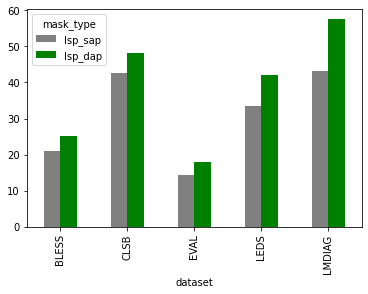

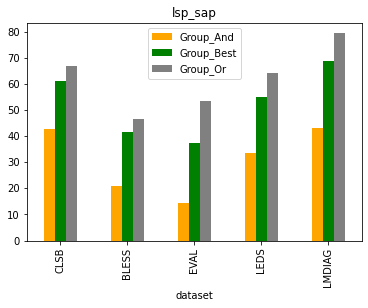

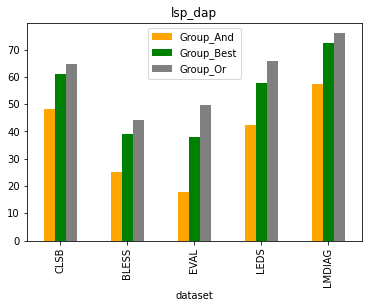

In [19]:
# for name, group in dataset_to_df_res.groupby('dataset'):
#     display(group)

dataset_to_df_res[['dataset','Group_And', 'mask_type']].pivot(index='dataset',
                                                              columns=['mask_type'], 
                                                              values='Group_And').reindex(['lsp_sap', 'lsp_dap'], axis=1).plot(kind='bar',
                                                                                                                              color=['grey','green'])

df1 = dataset_to_df_res.query("mask_type=='lsp_sap'")[['dataset','Group_And', 'Group_Best', 'Group_Or']]
df1.plot(x='dataset',  kind='bar', color=['orange', 'green', 'grey'], title='lsp_sap')
df1.index = df1['dataset']
df1 = df1.reindex(['BLESS', 'LMDIAG', 'CLSB', 'EVAL', 'LEDS']).T


df2 = dataset_to_df_res.query("mask_type=='lsp_dap'")[['dataset','Group_And', 'Group_Best', 'Group_Or']]
df2.plot(x='dataset',  kind='bar', color=['orange', 'green', 'grey'], title='lsp_dap' )
df2.index = df2['dataset']
df2 = df2.reindex(['BLESS', 'LMDIAG', 'CLSB', 'EVAL', 'LEDS']).T

display(df1)
display(df2)
print(df1.to_latex())
print(df2.to_latex())


In [39]:
df = pd.read_csv("../../log/bert-large-uncased/clsb/consistency_group/IsA.lsp_dap.csv")
# df.head()

pred_col_sg=[x for x in df.columns if 'mask_sentences_singular_' in x and 'score' not in x]
pred_col_pl=[x for x in df.columns if 'mask_sentences_plural_' in x and 'score' not in x]
df[pred_col_pl]
# pred_col_pl
# df.columns

,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6
0,"['[MASK] such as aeroplanes and airplanes.', '...","['[MASK], including aeroplanes and airplanes.'...","['[MASK], especially aeroplanes and airplanes....","['aeroplanes, airplanes and other [MASK].', 'a...","['aeroplanes, airplanes or other [MASK].', 'ae...","['such [MASK] as aeroplanes and airplanes.', '..."
1,"['[MASK] such as alligators and snakes.', '[MA...","['[MASK], including alligators and snakes.', '...","['[MASK], especially alligators and snakes.', ...","['alligators, snakes and other [MASK].', 'alli...","['alligators, snakes or other [MASK].', 'allig...","['such [MASK] as alligators and snakes.', 'suc..."
2,"['[MASK] such as alligators and snakes.', '[MA...","['[MASK], including alligators and snakes.', '...","['[MASK], especially alligators and snakes.', ...","['alligators, snakes and other [MASK].', 'alli...","['alligators, snakes or other [MASK].', 'allig...","['such [MASK] as alligators and snakes.', 'suc..."
3,"['[MASK] such as alligators and snakes.', '[MA...","['[MASK], including alligators and snakes.', '...","['[MASK], especially alligators and snakes.', ...","['alligators, snakes and other [MASK].', 'alli...","['alligators, snakes or other [MASK].', 'allig...","['such [MASK] as alligators and snakes.', 'suc..."
4,"['[MASK] such as alligators and snakes.', '[MA...","['[MASK], including alligators and snakes.', '...","['[MASK], especially alligators and snakes.', ...","['alligators, snakes and other [MASK].', 'alli...","['alligators, snakes or other [MASK].', 'allig...","['such [MASK] as alligators and snakes.', 'suc..."
...,...,...,...,...,...,...
1305,"['[MASK] such as yoyos and mexicos.', '[MASK] ...","['[MASK], including yoyos and mexicos.', '[MAS...","['[MASK], especially yoyos and mexicos.', '[MA...","['yoyos, mexicos and other [MASK].', 'yoyos, c...","['yoyos, mexicos or other [MASK].', 'yoyos, ca...","['such [MASK] as yoyos and mexicos.', 'such [M..."
1306,"['[MASK] such as yoyos and mexicos.', '[MASK] ...","['[MASK], including yoyos and mexicos.', '[MAS...","['[MASK], especially yoyos and mexicos.', '[MA...","['yoyos, mexicos and other [MASK].', 'yoyos, c...","['yoyos, mexicos or other [MASK].', 'yoyos, ca...","['such [MASK] as yoyos and mexicos.', 'such [M..."
1307,"['[MASK] such as zebras and elephants.', '[MAS...","['[MASK], including zebras and elephants.', '[...","['[MASK], especially zebras and elephants.', '...","['zebras, elephants and other [MASK].', 'zebra...","['zebras, elephants or other [MASK].', 'zebras...","['such [MASK] as zebras and elephants.', 'such..."
1308,"['[MASK] such as zebras and elephants.', '[MAS...","['[MASK], including zebras and elephants.', '[...","['[MASK], especially zebras and elephants.', '...","['zebras, elephants and other [MASK].', 'zebra...","['zebras, elephants or other [MASK].', 'zebras...","['such [MASK] as zebras and elephants.', 'such..."


In [24]:
Tv = {'BreakingBad':100, 'GameOfThrones':1292, 'TMKUC' : 88}
 
Keymax = max(zip(Tv.values(), Tv.keys()))[1]
print(Keymax)

GameOfThrones


In [19]:
from collections import defaultdict 

def get_dataset_to_respath(print_flag=False):
    # remote path 
    dataset_to_respath = {'hypernymsuite-BLESS': 'log/bert-large-uncased/hypernymsuite/BLESS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'lm_diagnostic_extended-singular': 'log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv', 'clsb-singular': 'log/bert-large-uncased/clsb/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.CLSB.csv', 'hypernymsuite-LEDS': 'log/bert-large-uncased/hypernymsuite/LEDS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'hypernymsuite-EVAL': 'log/bert-large-uncased/hypernymsuite/EVAL/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'hypernymsuite-SHWARTZ': 'log/bert-large-uncased/hypernymsuite/SHWARTZ/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv'}

    source_dir = 'spartan:~/cogsci/DAP/'
    target_dir = '../'
    dataset_to_localpath = defaultdict()
    dataset_rename = {
        'hypernymsuite-BLESS': 'BLESS', 'lm_diagnostic_extended-singular': 'LMDIAG', 'clsb-singular':'CLSB', 'hypernymsuite-LEDS': 'LEDS', 'hypernymsuite-EVAL': 'EVAL', 'hypernymsuite-SHWARTZ': 
        "SHWARTZ"
    }
    for dataset, path in dataset_to_respath.items():
        path = path.replace(".tsv", ".csv")
        source_path = source_dir + path 
        dataset_l1 = dataset.split("-")[0]
        dataset_l2 = dataset.split("-")[1] 
        target_path = target_dir + path
        scp_string = f"!scp {source_path} {target_path}"
        if print_flag:
            print(scp_string)
            print()
#         print(target_path)
        dataset_to_localpath[dataset_rename[dataset]] = target_path 
#     print(dataset_to_localpath)
    return dataset_to_localpath
dataset_to_localpath = get_dataset_to_respath()

!scp spartan:~/cogsci/DAP/log/bert-large-uncased/hypernymsuite/BLESS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv ../log/bert-large-uncased/hypernymsuite/BLESS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv

!scp spartan:~/cogsci/DAP/log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv ../log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_

In [20]:
!scp spartan:~/cogsci/DAP/log/bert-large-uncased/hypernymsuite/BLESS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv ../log/bert-large-uncased/hypernymsuite/BLESS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv

!scp spartan:~/cogsci/DAP/log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv ../log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv

!scp spartan:~/cogsci/DAP/log/bert-large-uncased/clsb/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.CLSB.csv ../log/bert-large-uncased/clsb/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.CLSB.csv

!scp spartan:~/cogsci/DAP/log/bert-large-uncased/hypernymsuite/LEDS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv ../log/bert-large-uncased/hypernymsuite/LEDS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv

!scp spartan:~/cogsci/DAP/log/bert-large-uncased/hypernymsuite/EVAL/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv ../log/bert-large-uncased/hypernymsuite/EVAL/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv

!scp spartan:~/cogsci/DAP/log/bert-large-uncased/hypernymsuite/SHWARTZ/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv ../log/bert-large-uncased/hypernymsuite/SHWARTZ/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv

/home/chunhua/.bashrc: line 103: bind: warning: line editing not enabled
/home/chunhua/.bashrc: line 104: bind: warning: line editing not enabled
exp_data_results_anchor_type_Coordinate_remov 100%   13MB  85.7MB/s   00:00    
/home/chunhua/.bashrc: line 103: bind: warning: line editing not enabled
/home/chunhua/.bashrc: line 104: bind: warning: line editing not enabled
exp_data_results_anchor_type_Coordinate_remov 100% 6674KB  70.3MB/s   00:00    
/home/chunhua/.bashrc: line 103: bind: warning: line editing not enabled
/home/chunhua/.bashrc: line 104: bind: warning: line editing not enabled
exp_data_results_anchor_type_Coordinate_remov 100%   14MB  77.0MB/s   00:00    
/home/chunhua/.bashrc: line 103: bind: warning: line editing not enabled
/home/chunhua/.bashrc: line 104: bind: warning: line editing not enabled
exp_data_results_anchor_type_Coordinate_remov 100%   13MB  73.2MB/s   00:00    
/home/chunhua/.bashrc: line 103: bind: warning: line editing not enabled
/home/chunhua/.bashrc: 